In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.pyplot import subplot_mosaic
import os
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations
from scipy.stats import pearsonr, fisher_exact
import ast

In [14]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [15]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [16]:
def fig_to_panels(fig, axes, output_dir):
    # Save individual panels of a figure 
    
    for panel_name, ax in axes.items():
        # Extract the panel title
        panel_title = ax.get_title()

        # Sanitize the panel title to use in filenames
        safe_title = panel_title.replace(" ", "_").replace("/", "_").replace("\n", "_").lower()

        # Create the filename for the current panel
        output_file = os.path.join(output_dir,safe_title)

        # Adjust the bounding box to include everything (labels, titles, etc.)
        extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

        # Save the individual panel using the adjusted bounding box
        fig.savefig(output_file + '.pdf', bbox_inches=extent, dpi=300)
        fig.savefig(output_file + '.png', bbox_inches=extent)

        print(f"Saved panel '{panel_title}' to {output_file}")


In [17]:
def network_to_adj(network_path):
    network = pd.read_csv(
        network_path,
        usecols=['complex1', 'complex2', 'adj']
    )

    # Add a mirrored version of the network to make it symmetric
    network_mirrored = network.copy()
    network_mirrored.columns = ['complex2', 'complex1', 'adj']
    network = pd.concat([network, network_mirrored], ignore_index=True)

    adj = network.pivot(index='complex1', columns='complex2', values='adj').fillna(0)
    return adj

In [18]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff' # solid dark
ncolor2 = '#00728e80' # alpha=0.5
lightncolor = '#7fb8c6ff' # solid light

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'
lighttcolor = '#d49980ff'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

lightgray = '#C8CAD4'

orangecolor = '#e69426'
orangecolor2 = '#e6942680'
lightorangecolor = '#f2c992ff'

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import false_discovery_control

In [8]:
wgcnas = [
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/nerve/normal/nerve_tibial/wgcna_nerve_tibial.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/blood/normal/whole_blood/wgcna_whole_blood.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/rectum/tumor/rectum_adenocarcinoma/wgcna_rectum_adenocarcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/salivary_gland/normal/minor_salivary_gland/wgcna_minor_salivary_gland.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/uterus/normal/uterus/wgcna_uterus.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/uterus/tumor/uterine_carcinosarcoma/wgcna_uterine_carcinosarcoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/kidney/normal/kidney_cortex/wgcna_kidney_cortex.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/kidney/tumor/kidney_papillary_cell_carcinoma/wgcna_kidney_papillary_cell_carcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/kidney/tumor/kidney_chromophobe/wgcna_kidney_chromophobe.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/kidney/tumor/kidney_clear_cell_carcinoma/wgcna_kidney_clear_cell_carcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/heart/normal/heart_atrial_appendage/wgcna_heart_atrial_appendage.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/heart/normal/heart_left_ventricle/wgcna_heart_left_ventricle.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_cortex/wgcna_brain_cortex.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_frontal_cortex_ba9/wgcna_brain_frontal_cortex_ba9.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_hippocampus/wgcna_brain_hippocampus.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_spinal_cord_cervical_c1/wgcna_brain_spinal_cord_cervical_c1.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_hypothalamus/wgcna_brain_hypothalamus.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_anterior_cingulate_cortex_ba24/wgcna_brain_anterior_cingulate_cortex_ba24.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_caudate_basal_ganglia/wgcna_brain_caudate_basal_ganglia.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_nucleus_accumbens_basal_ganglia/wgcna_brain_nucleus_accumbens_basal_ganglia.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_substantia_nigra/wgcna_brain_substantia_nigra.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_putamen_basal_ganglia/wgcna_brain_putamen_basal_ganglia.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_cerebellar_hemisphere/wgcna_brain_cerebellar_hemisphere.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_cerebellum/wgcna_brain_cerebellum.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/normal/brain_amygdala/wgcna_brain_amygdala.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/tumor/brain_lower_grade_glioma/wgcna_brain_lower_grade_glioma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/brain/tumor/glioblastoma_multiforme/wgcna_glioblastoma_multiforme.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/adrenal_gland/normal/adrenal_gland/wgcna_adrenal_gland.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/adrenal_gland/tumor/adrenocortical_cancer/wgcna_adrenocortical_cancer.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/testis/tumor/testicular_germ_cell_tumor/wgcna_testicular_germ_cell_tumor.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/normal/liver/wgcna_liver.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/liver/tumor/liver_hepatocellular_carcinoma/wgcna_liver_hepatocellular_carcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/normal/prostate/wgcna_prostate.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/prostate/tumor/prostate_adenocarcinoma/wgcna_prostate_adenocarcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/thymus/tumor/thymoma/wgcna_thymoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/vagina/normal/vagina/wgcna_vagina.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/lung/normal/lung/wgcna_lung.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/lung/tumor/lung_squamous_cell_carcinoma/wgcna_lung_squamous_cell_carcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/lung/tumor/lung_adenocarcinoma/wgcna_lung_adenocarcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/bladder/tumor/bladder_urothelial_carcinoma/wgcna_bladder_urothelial_carcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/breast/normal/breast_mammary_tissue/wgcna_breast_mammary_tissue.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/breast/tumor/breast_invasive_carcinoma/wgcna_breast_invasive_carcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/adipose_tissue/normal/adipose_visceral_omentum/wgcna_adipose_visceral_omentum.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/adipose_tissue/normal/adipose_subcutaneous/wgcna_adipose_subcutaneous.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/blood_vessel/normal/artery_aorta/wgcna_artery_aorta.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/blood_vessel/normal/artery_coronary/wgcna_artery_coronary.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/blood_vessel/normal/artery_tibial/wgcna_artery_tibial.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/cervix/tumor/cervical_and_endocervical_cancer/wgcna_cervical_and_endocervical_cancer.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/ovary/normal/ovary/wgcna_ovary.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/ovary/tumor/ovarian_serous_cystadenocarcinoma/wgcna_ovarian_serous_cystadenocarcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/muscle/normal/muscle_skeletal/wgcna_muscle_skeletal.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/endometrium/tumor/uterine_corpus_endometrioid_carcinoma/wgcna_uterine_corpus_endometrioid_carcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/lining_of_body_cavities/tumor/mesothelioma/wgcna_mesothelioma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/skin/normal/skin_sun_exposed_lower_leg/wgcna_skin_sun_exposed_lower_leg.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/skin/normal/skin_not_sun_exposed_suprapubic/wgcna_skin_not_sun_exposed_suprapubic.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/skin/tumor/skin_cutaneous_melanoma/wgcna_skin_cutaneous_melanoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/pancreas/normal/pancreas/wgcna_pancreas.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/pancreas/tumor/pancreatic_adenocarcinoma/wgcna_pancreatic_adenocarcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/thyroid/normal/thyroid/wgcna_thyroid.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/thyroid/tumor/thyroid_carcinoma/wgcna_thyroid_carcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/eye/tumor/uveal_melanoma/wgcna_uveal_melanoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/pituitary/normal/pituitary/wgcna_pituitary.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/bile_duct/tumor/cholangiocarcinoma/wgcna_cholangiocarcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/small_intestine/normal/small_intestine_terminal_ileum/wgcna_small_intestine_terminal_ileum.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/soft_tissue_bone/tumor/sarcoma/wgcna_sarcoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/colon/normal/colon_sigmoid/wgcna_colon_sigmoid.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/colon/normal/colon_transverse/wgcna_colon_transverse.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/colon/tumor/colon_adenocarcinoma/wgcna_colon_adenocarcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/spleen/normal/spleen/wgcna_spleen.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/head_and_neck_region/tumor/head_and_neck_squamous_cell_carcinoma/wgcna_head_and_neck_squamous_cell_carcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/lymphatic_tissue/tumor/diffuse_large_bcell_lymphoma/wgcna_diffuse_large_bcell_lymphoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/paraganglia/tumor/pheochromocytoma_and_paraganglioma/wgcna_pheochromocytoma_and_paraganglioma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/esophagus/normal/esophagus_gastroesophageal_junction/wgcna_esophagus_gastroesophageal_junction.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/esophagus/normal/esophagus_muscularis/wgcna_esophagus_muscularis.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/esophagus/normal/esophagus_mucosa/wgcna_esophagus_mucosa.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/esophagus/tumor/esophageal_carcinoma/wgcna_esophageal_carcinoma.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/stomach/normal/stomach/wgcna_stomach.p',
'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/stomach/tumor/stomach_adenocarcinoma/wgcna_stomach_adenocarcinoma.p',
]

In [16]:
import PyWGCNA

colors = set()

print('Number of WGCNAs: ', len(wgcnas))

for wgcna in wgcnas:
    WGCNA = PyWGCNA.readWGCNA(wgcna)
    colors.update(set(WGCNA.datExpr.var.dynamicColors))
    if 'grey' in colors:
        print(wgcna)
        print(WGCNA.datExpr.var.dynamicColors.value_counts())

Number of WGCNAs:  78
Reading wgcna_nerve_tibial WGCNA done!
Reading wgcna_whole_blood WGCNA done!
Reading wgcna_rectum_adenocarcinoma WGCNA done!
Reading wgcna_minor_salivary_gland WGCNA done!
Reading wgcna_uterus WGCNA done!
Reading wgcna_uterine_carcinosarcoma WGCNA done!
Reading wgcna_kidney_cortex WGCNA done!
Reading wgcna_kidney_papillary_cell_carcinoma WGCNA done!
Reading wgcna_kidney_chromophobe WGCNA done!
Reading wgcna_kidney_clear_cell_carcinoma WGCNA done!
Reading wgcna_heart_atrial_appendage WGCNA done!
Reading wgcna_heart_left_ventricle WGCNA done!
Reading wgcna_brain_cortex WGCNA done!
Reading wgcna_brain_frontal_cortex_ba9 WGCNA done!
Reading wgcna_brain_hippocampus WGCNA done!
Reading wgcna_brain_spinal_cord_cervical_c1 WGCNA done!
Reading wgcna_brain_hypothalamus WGCNA done!
Reading wgcna_brain_anterior_cingulate_cortex_ba24 WGCNA done!
Reading wgcna_brain_caudate_basal_ganglia WGCNA done!
Reading wgcna_brain_nucleus_accumbens_basal_ganglia WGCNA done!
Reading wgcna_b

In [24]:
wgcna

'/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/stomach/tumor/stomach_adenocarcinoma/wgcna_stomach_adenocarcinoma.p'

In [18]:
colors

{'antiquewhite',
 'bisque',
 'black',
 'blanchedalmond',
 'brown',
 'burlywood',
 'chocolate',
 'coral',
 'darkgoldenrod',
 'darkgrey',
 'darkorange',
 'darkred',
 'darksalmon',
 'dimgrey',
 'firebrick',
 'floralwhite',
 'gainsboro',
 'indianred',
 'lightcoral',
 'lightgrey',
 'lightsalmon',
 'linen',
 'maroon',
 'mistyrose',
 'moccasin',
 'navajowhite',
 'orange',
 'orangered',
 'papayawhip',
 'peachpuff',
 'peru',
 'red',
 'rosybrown',
 'saddlebrown',
 'salmon',
 'sandybrown',
 'seashell',
 'sienna',
 'silver',
 'snow',
 'tan',
 'tomato',
 'wheat',
 'white',
 'whitesmoke'}

In [19]:
WGCNA.datExpr.var.dynamicColors

RAB4B     whitesmoke
TIGAR      gainsboro
RNF44       darkgrey
DNAH3     lightcoral
RPL23A     gainsboro
             ...    
POMZP3      darkgrey
EIF5B      rosybrown
KIF16B      darkgrey
BATF3        dimgrey
PPP6R1    whitesmoke
Name: dynamicColors, Length: 14202, dtype: object

In [25]:
# '/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/stomach/tumor/stomach_adenocarcinoma/wgcna_stomach_adenocarcinoma.p'
WGCNA.datExpr.var[['dynamicColors', 'moduleColors', 'moduleLabels']].value_counts()

dynamicColors  moduleColors  moduleLabels
black          black         0               4702
silver         silver        7               2611
gainsboro      gainsboro     3               2154
whitesmoke     whitesmoke    8               1652
darkgrey       darkgrey      1               1313
dimgrey        dimgrey       2                899
rosybrown      rosybrown     6                714
indianred      indianred     4                114
lightcoral     lightcoral    5                 43
Name: count, dtype: int64

In [21]:
WGCNA.datExpr.var.moduleLabels.value_counts()

moduleLabels
0    4702
7    2611
3    2154
8    1652
1    1313
2     899
6     714
4     114
5      43
Name: count, dtype: int64

In [34]:
# -------- Same Module ---------                                                                                              
                                                                                                                              
print("Checking which gene pairs are in the same module")                                                                     
                                                                                                                              
same_module = WGCNA.datExpr.var['moduleLabels'].values[:, None] == WGCNA.datExpr.var['moduleLabels'].values                   
same_module = pd.DataFrame(data=same_module, index=WGCNA.datExpr.var.index, columns=WGCNA.datExpr.var.index)                  
                                                                                                                              
# save same_module as csv                                                                                                     
#same_module.to_csv(os.path.join(output_path, "same_module.csv.gz"))                                                           
                                                                                                                              
# Get idxs corresponding to upper triangle (diagonal excluded)                                                                
idxs_x, idxs_y = np.triu_indices(same_module.shape[0], 1)                                                                     
                                                                                                                              
same_module_vals = same_module.values[idxs_x, idxs_y]                                                                         
                                                                                                                              
total_pairs = same_module_vals.shape[0]                                                                                       
n_same_module = same_module_vals.sum()   

Checking which gene pairs are in the same module


dynamicColors
brown         11187
dimgrey        1198
rosybrown       815
black           480
snow            260
lightcoral      200
lightgrey       121
Name: count, dtype: int64

In [36]:
WGCNA.datExpr.var.moduleColors.value_counts()

moduleColors
brown         11187
dimgrey        1198
rosybrown       815
black           480
snow            260
lightcoral      200
lightgrey       121
Name: count, dtype: int64

# Compare

In [19]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/compare_results.csv', index_col=0)
df = df.drop(columns=['avg_coev_tom_correlation'])
df = df[df.index != 'testis']
df['interactions_mannwhitneyu_p_adj'] = false_discovery_control(df['interactions_mannwhitneyu_p'], method='bh')

In [20]:
auroc_a = df['interactions_auroc']
auroc_t = df.query('condition == "tumor"')['interactions_auroc']
auroc_n = df.query('condition == "normal"')['interactions_auroc']

print('AUROC')

print('All tissues:', auroc_a.mean(), '+/-', np.std(auroc_a))
print('Normal', auroc_n.mean(), '+/-', np.std(auroc_n))
print('Tumor', auroc_t.mean(), '+/-', np.std(auroc_t))

ua = df['interactions_mannwhitneyu_U']
ut = df.query('condition == "tumor"')['interactions_mannwhitneyu_U']
un = df.query('condition == "normal"')['interactions_mannwhitneyu_U']

AUROC
All tissues: 0.6165693346411175 +/- 0.03869659366368164
Normal 0.5913339627313167 +/- 0.020279851115496902
Tumor 0.6528451817614561 +/- 0.028764581664141135


In [21]:
df['-log10_mannwhitneyu_p_adj'] = -np.log10(df['interactions_mannwhitneyu_p_adj'])

In [22]:
df.drop(columns='interactions_mannwhitneyu_p', inplace=True)
df.drop(columns='interactions_mannwhitneyu_p_adj', inplace=True)

In [23]:
same_module_df = df[['condition', 'n_interactions_same_module', 'tot_interactions']].copy()

In [24]:
t_tot_ints = same_module_df.query('condition == "tumor"')['tot_interactions'].sum()
n_tot_ints = same_module_df.query('condition == "normal"')['tot_interactions'].sum()

t_same_ints = same_module_df.query('condition == "tumor"')['n_interactions_same_module'].sum()
n_same_ints = same_module_df.query('condition == "normal"')['n_interactions_same_module'].sum()

table = [
    [t_same_ints, t_tot_ints-t_same_ints],
    [n_same_ints, n_tot_ints-n_same_ints]
]

/var/tmp/pbs.374199.pbs01/ipykernel_9416/2069307434.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
/var/tmp/pbs.374199.pbs01/ipykernel_9416/2069307434.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
/var/tmp/pbs.374199.pbs01/ipykernel_9416/2069307434.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
/var/tmp/pbs.374199.pbs01/ipykerne

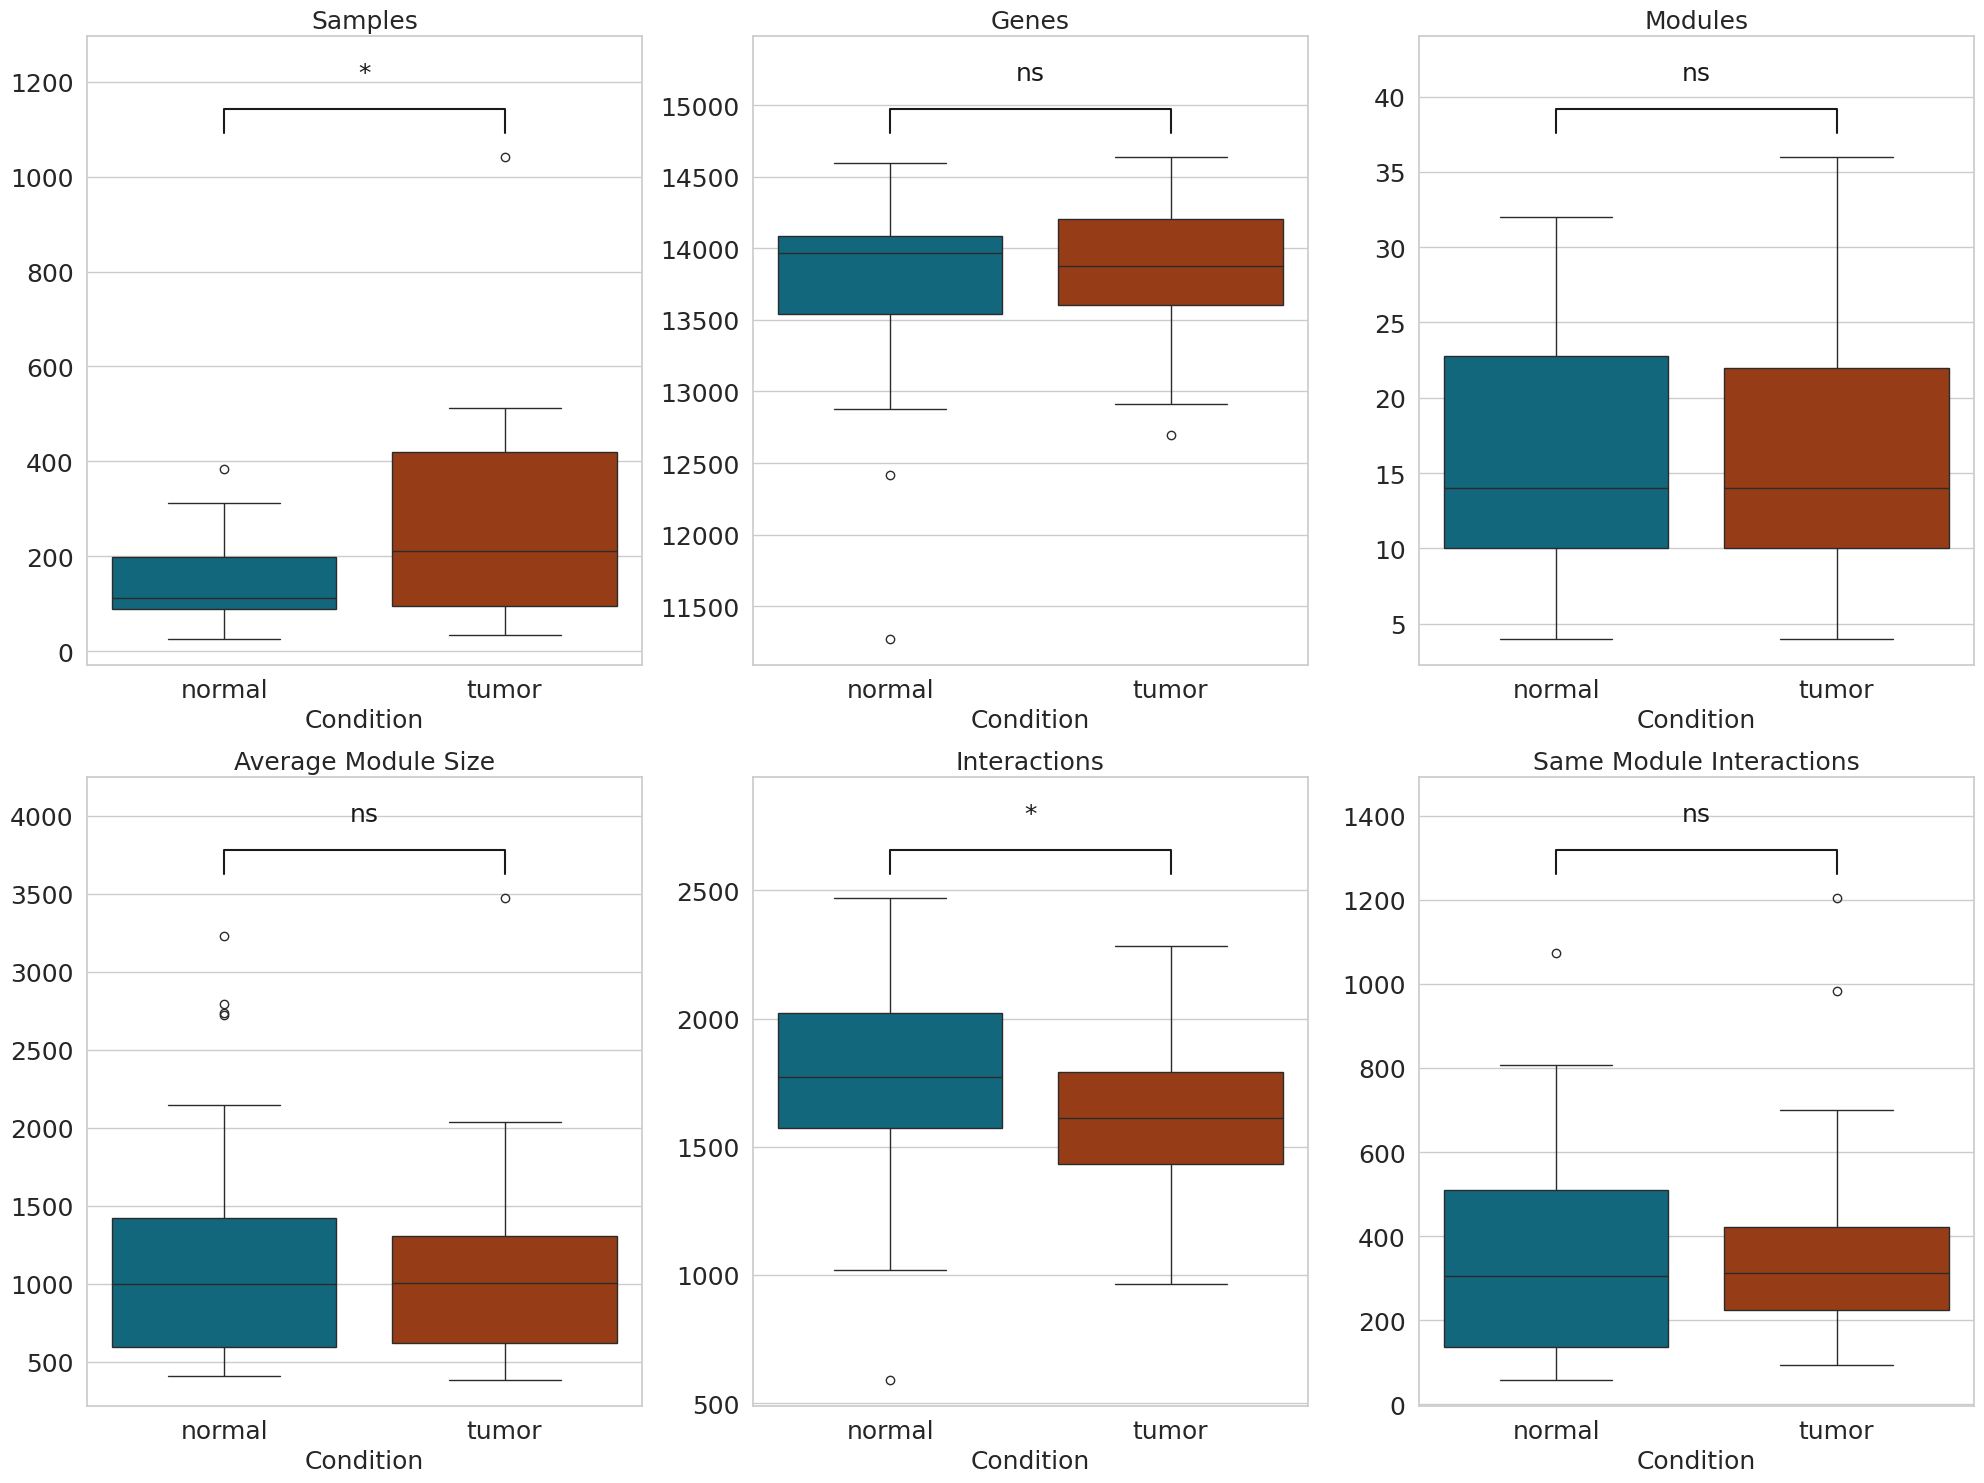

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

fs = 18

# Title dictionary for subplots
title_dict = {
    'n_samples': 'Samples',
    'n_genes': 'Genes',
    'n_modules': 'Modules',
    'avg_module_size': 'Average Module Size',
    #'avg_degree': 'Average Degree',
    #'avg_intramodular_degree': 'Average Intramodular Degree',
    'tot_interactions': 'Interactions',
    'n_interactions_same_module': 'Same Module Interactions',
    #'interactions_auroc': 'AUROC',
    #'interactions_mannwhitneyu_U': 'Mann-Whitney $U$',
    #'-log10_mannwhitneyu_p_adj': 'Mann-Whitney $-log_{10}{p_{adj}}$',
}

# Set the style
sns.set(style="whitegrid")

# Define font size

# Function to perform Mann-Whitney U test and return p-value
def compute_p_value(data, column):
    """Compute p-value for Mann-Whitney U test."""
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    _, p_value = mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
    return p_value

# Function to add significance bars to the boxplot
def add_significance(ax, data, column, p_value):
    """ Adds significance bars to the given axes object based on p-value. """
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # Not significant

    # Calculate maximum y-value and add space for significance bar
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    y_max = max(normal_data.max(), tumor_data.max())
    y_min = min(normal_data.min(), tumor_data.min())
    y_offset = 0.2 * (y_max - y_min if y_max > y_min else 1)

    h = 0.05 * (y_max - y_min)  # Height of the significance bar
    y_bar_start = y_max + h
    y_bar_end = y_max + 2 * h

    x1, x2 = 0, 1
    col = 'k'

    # Plot the significance bar
    ax.plot([x1, x1, x2, x2], [y_bar_start, y_bar_end, y_bar_end, y_bar_start], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y_bar_end + h, significance, ha='center', va='bottom', color=col, fontsize=fs)

    # Update the y-axis limit to make space for the significance bar
    ax.set_ylim(top=y_bar_end + h * 3)  # Adding extra space to avoid overlap with titles

# Define columns to plot based on the title_dict
columns = list(title_dict.keys())

# Collect p-values for FDR correction
p_values = [compute_p_value(df, column) for column in columns]

# Apply FDR correction
#p_values = stats.false_discovery_control(p_values, method='bh')

# Create a dictionary of corrected p-values
p_value_dict = dict(zip(columns, p_values))

# Plot boxplots for each column
plt.figure(figsize=(20, 15))  # Adjusted figure size for better spacing

subplot_shape = (2,3)

# Plot the countplot for 'condition'
#plt.subplot(subplot_shape[0], subplot_shape[1], 1)
#sns.countplot(x='condition', data=df, palette=[ncolor, tcolor])
#plt.title('Tissues', fontsize=fs)
#plt.xlabel('Condition', fontsize=fs)
#plt.ylabel('', fontsize=fs)
#plt.xticks(fontsize=fs)
#plt.yticks(fontsize=fs)

# Plot boxplots for each column in the title_dict
for i, column in enumerate(columns):
    plt.subplot(subplot_shape[0], subplot_shape[1], i + 1)
    ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
    plt.title(title_dict[column], fontsize=fs)
    plt.xlabel('Condition', fontsize=fs)
    plt.ylabel('', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    # Add significance bars
    add_significance(ax, df, column, p_value_dict[column])

plt.tight_layout()

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_all.pdf')

# Show the plot
plt.show()


In [26]:
df['prob_same_module'] = df.n_interactions_same_module / df.tot_interactions

/var/tmp/pbs.374199.pbs01/ipykernel_9416/4241850758.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/tmp/pbs.374199.pbs01/ipykernel_9416/4241850758.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


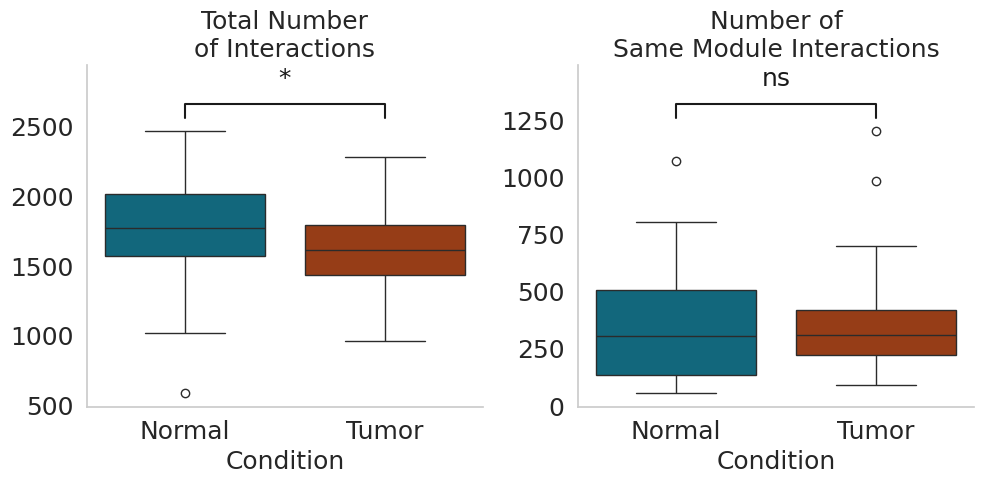

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Title dictionary for subplots
title_dict = {
    'tot_interactions': 'Total Number\nof Interactions',
    'n_interactions_same_module': 'Number of\nSame Module Interactions',
    #'prob_same_module': 'Fraction of\nSame Module Interactions'
}

# Set the style
sns.set(style="whitegrid")

# Define font size
fs = 18

# Function to perform Mann-Whitney U test and return p-value
def compute_p_value(data, column):
    """Compute p-value for Mann-Whitney U test."""
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    _, p_value = mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
    return p_value

# Function to add significance bars to the boxplot
def add_significance(ax, data, column, p_value):
    """ Adds significance bars to the given axes object based on p-value. """
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # Not significant

    # Calculate maximum y-value and add space for significance bar
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    y_max = max(normal_data.max(), tumor_data.max())
    y_min = min(normal_data.min(), tumor_data.min())
    y_offset = 0.2 * (y_max - y_min if y_max > y_min else 1)

    h = 0.05 * (y_max - y_min)  # Height of the significance bar
    y_bar_start = y_max + h
    y_bar_end = y_max + 2 * h

    x1, x2 = 0, 1
    col = 'k'

    # Plot the significance bar
    ax.plot([x1, x1, x2, x2], [y_bar_start, y_bar_end, y_bar_end, y_bar_start], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y_bar_end + h, significance, ha='center', va='bottom', color=col, fontsize=fs)

    # Update the y-axis limit to make space for the significance bar
    ax.set_ylim(top=y_bar_end + h * 3)  # Adding extra space to avoid overlap with titles

# Define columns to plot based on the title_dict
columns = list(title_dict.keys())

# Collect p-values for FDR correction
p_values = [compute_p_value(df, column) for column in columns]

# Apply FDR correction
#p_values = false_discovery_control(p_values, method='bh')

# Create a dictionary of corrected p-values
p_value_dict = dict(zip(columns, p_values))

# Plot boxplots for each column

subplot_shape = (1,len(title_dict))

fig, axes = plt.subplots(subplot_shape[0], subplot_shape[1], figsize=(5 * subplot_shape[1], 5))

# Plot boxplots for each column in the title_dict
for i, column in enumerate(columns):
    sns.boxplot(
        x='condition',
        y=column,
        data=df.replace({'normal': 'Normal', 'tumor': 'Tumor'}),
        palette=[ncolor, tcolor],
        ax=axes[i]
    )
    axes[i].set_title(title_dict[column], fontsize=fs)
    axes[i].set_xlabel('Condition', fontsize=fs)
    axes[i].set_ylabel('', fontsize=fs)
    axes[i].tick_params(labelsize=fs)
    axes[i].grid(False)
    axes[i].spines[['right', 'top']].set_visible(False)

    #axes[i].xticks(fontsize=fs)
    #axes[i].yticks(fontsize=fs)

    # Add significance bars
    add_significance(axes[i], df, column, p_value_dict[column])

plt.tight_layout()

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_interactions.pdf')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_interactions.png')

# Show the plot
plt.show()


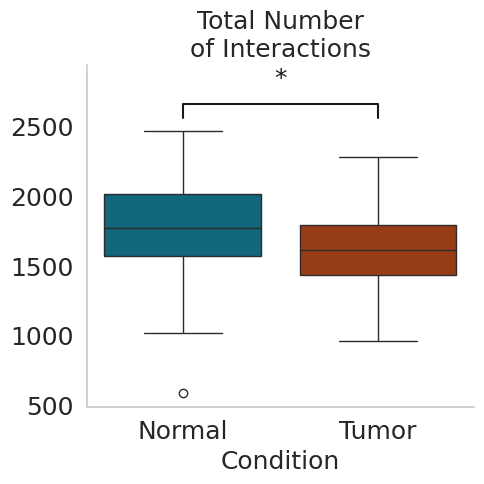

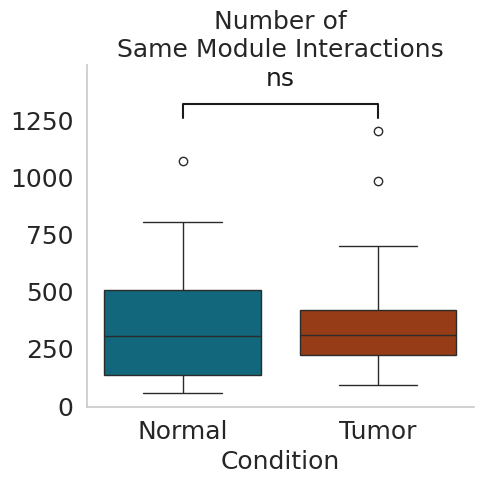

In [28]:
# First figure: Total Number of Interactions
fig1, ax1 = plt.subplots(figsize=(5, 5))
sns.boxplot(
    x='condition',
    y='tot_interactions',
    hue='condition',
    data=df.replace({'normal': 'Normal', 'tumor': 'Tumor'}),
    palette=[ncolor, tcolor],
    ax=ax1
)
ax1.set_title(title_dict['tot_interactions'], fontsize=fs)
ax1.set_xlabel('Condition', fontsize=fs)
ax1.set_ylabel('', fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.grid(False)
ax1.spines[['right', 'top']].set_visible(False)

# Add significance bars for the first plot
add_significance(ax1, df, 'tot_interactions', p_value_dict['tot_interactions'])

# Save the first figure
plt.tight_layout()
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/interactions_total.pdf')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/interactions_total.png')

# Show the first plot
plt.show()

# Second figure: Number of Same Module CCIs
fig2, ax2 = plt.subplots(figsize=(5, 5))
sns.boxplot(
    x='condition',
    y='n_interactions_same_module',
    hue='condition',
    data=df.replace({'normal': 'Normal', 'tumor': 'Tumor'}),
    palette=[ncolor, tcolor],
    ax=ax2
)
ax2.set_title(title_dict['n_interactions_same_module'], fontsize=fs)
ax2.set_xlabel('Condition', fontsize=fs)
ax2.set_ylabel('', fontsize=fs)
ax2.tick_params(labelsize=fs)
ax2.grid(False)
ax2.spines[['right', 'top']].set_visible(False)

# Add significance bars for the second plot
add_significance(ax2, df, 'n_interactions_same_module', p_value_dict['n_interactions_same_module'])

# Save the second figure
plt.tight_layout()
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/interactions_same_module.pdf')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/interactions_same_module.png')

# Show the second plot
plt.show()


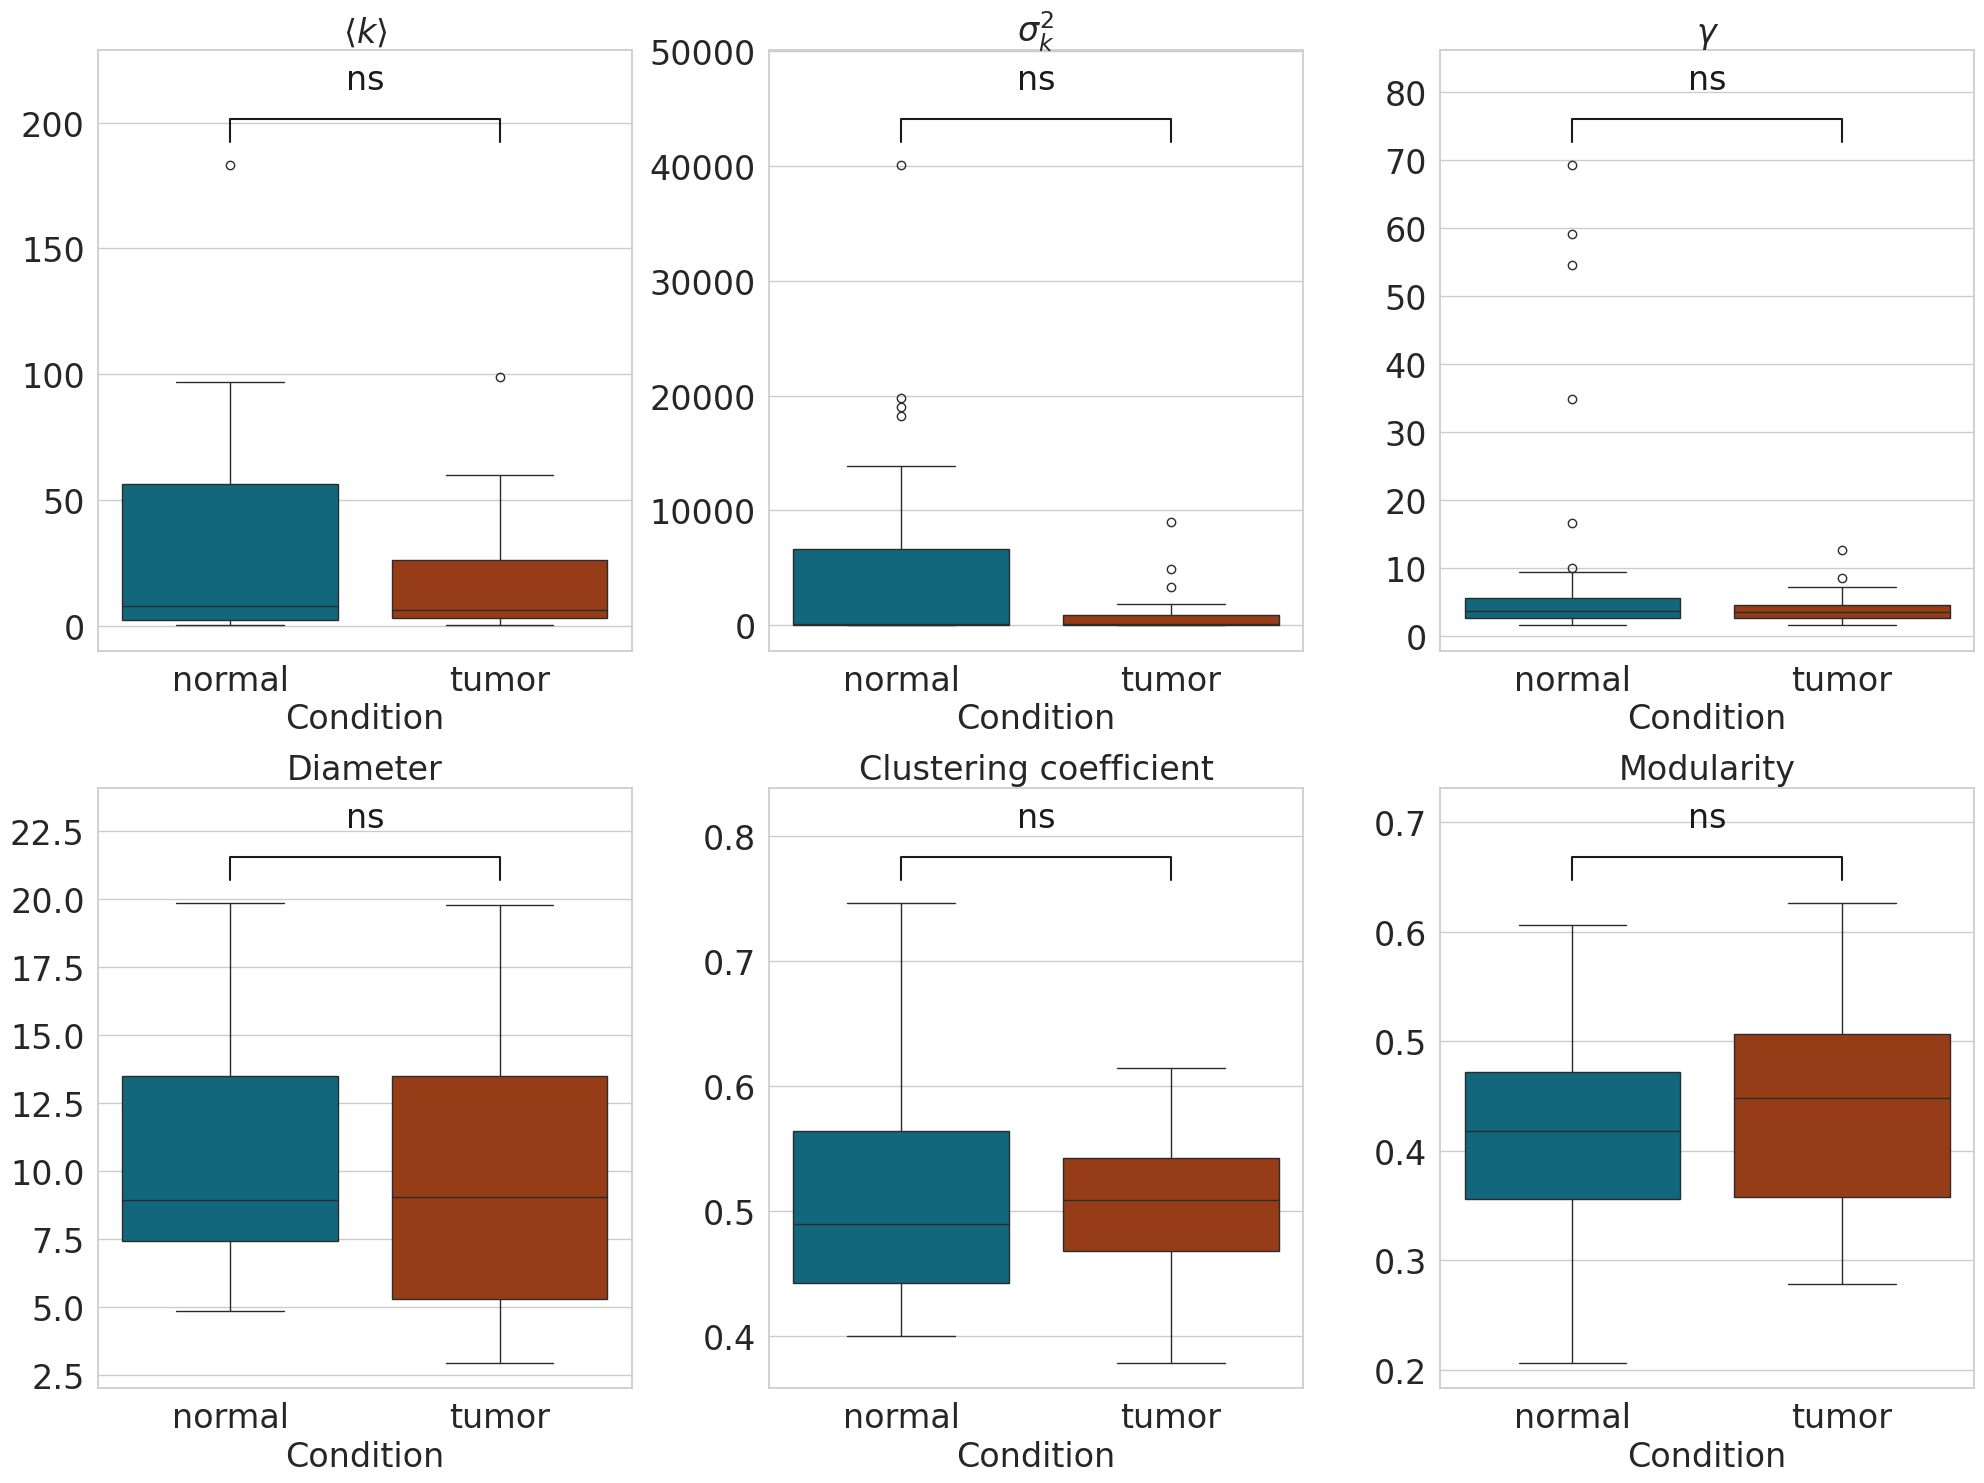

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Title dictionary for subplots
# Title dictionary for subplots
title_dict = {
    'avg_degree': '$ \langle k \\rangle $',
    #'avg_intramodular_degree': 'avg_intramodular_degree',
    'var_degree': '$ \sigma^2_{k}$',
    #'var_intramodular_degree': 'variance_intramodular',
    'powerlaw_alpha': '$\gamma$',
    #'avg_shortest_path': 'avg_path_length',
    'diameter': 'Diameter',
    'clustering_global': 'Clustering coefficient',
    'modularity': 'Modularity',
    #'powerlaw_xmin': 'xmin',
    #'powerlaw_sigma': 'sigma'
}

# Set the style
sns.set(style="whitegrid")

# Define font size
fs = 24

# Function to perform Mann-Whitney U test and return p-value
def compute_p_value(data, column):
    """Compute p-value for Mann-Whitney U test."""
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    _, p_value = mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
    return p_value

# Function to add significance bars to the boxplot
def add_significance(ax, data, column, p_value):
    """ Adds significance bars to the given axes object based on p-value. """
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # Not significant

    # Calculate maximum y-value and add space for significance bar
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    y_max = max(normal_data.max(), tumor_data.max())
    y_min = min(normal_data.min(), tumor_data.min())
    y_offset = 0.2 * (y_max - y_min if y_max > y_min else 1)

    h = 0.05 * (y_max - y_min)  # Height of the significance bar
    y_bar_start = y_max + h
    y_bar_end = y_max + 2 * h

    x1, x2 = 0, 1
    col = 'k'

    # Plot the significance bar
    ax.plot([x1, x1, x2, x2], [y_bar_start, y_bar_end, y_bar_end, y_bar_start], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y_bar_end + h, significance, ha='center', va='bottom', color=col, fontsize=fs)

    # Update the y-axis limit to make space for the significance bar
    ax.set_ylim(top=y_bar_end + h * 3)  # Adding extra space to avoid overlap with titles

# Define columns to plot based on the title_dict
columns = list(title_dict.keys())

# Collect p-values for FDR correction
p_values = [compute_p_value(df, column) for column in columns]

# Apply FDR correction
#p_values = stats.false_discovery_control(p_values, method='bh')

# Create a dictionary of corrected p-values
p_value_dict = dict(zip(columns, p_values))

# Plot boxplots for each column
plt.figure(figsize=(20, 15))  # Adjusted figure size for better spacing

subplot_shape = (2,3)

# Plot boxplots for each column in the title_dict
for i, column in enumerate(columns):
    plt.subplot(subplot_shape[0], subplot_shape[1], i + 1)
    ax = sns.boxplot(
        x='condition',
        y=column,
        hue='condition',
        data=df,
        palette=[ncolor, tcolor]
    )
    plt.title(title_dict[column], fontsize=fs)
    plt.xlabel('Condition', fontsize=fs)
    plt.ylabel('', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    # Add significance bars
    add_significance(ax, df, column, p_value_dict[column])

plt.tight_layout()

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_networks.pdf')

# Show the plot
plt.show()

In [30]:
#import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt
#
## Set the style
#sns.set_style("whitegrid", {'axes.grid': False})
#
## Define font size
#fs = 24
#
## Plot boxplots for each column
#plt.figure(figsize=(6, 12))  # Adjust the figure size to accommodate smaller vertical subplots
#
#title_dict = {
#    'interactions_auroc': 'AUROC',
#    #'interactions_mannwhitneyu_U': 'Rank-Sum $U$',
#    '-log10_mannwhitneyu_p_adj': 'Rank-Sum $-log_{10}{p_{adj}}$',
#}
#
#for i, column in enumerate(title_dict.keys()):
#    plt.subplot(len(title_dict), 1, i + 1)  # Change the subplot to vertical arrangement
#    sns.boxplot(x='condition', y=column, data=df.replace({'normal': 'Normal', 'tumor': 'Tumor'}), palette=[ncolor, tcolor])
#    plt.title(title_dict[column], fontsize=fs)
#    plt.xlabel('Condition', fontsize=fs)
#    plt.ylabel('', fontsize=fs)
#    plt.xticks(fontsize=fs)
#    plt.yticks(fontsize=fs)
#
#plt.tight_layout()
#
## Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_mannwhitneyu_auroc.pdf')
#
## Show the plot
#plt.show()
#

In [31]:
# COEVOLUTION

READ = True

if not READ:
    from sklearn.metrics import roc_curve, roc_auc_score
    from scipy.stats import mannwhitneyu
    from itertools import combinations, product

    # Function that generates and saves the ROC curve
    def generate_roc_curve(
        data,
        target_col,
        feature_col,
        name=None,
    ):
        # ROC curve using all gene pairs
        fpr, tpr, _ = roc_curve(data[target_col], data[feature_col])
        auroc = roc_auc_score(data[target_col], data[feature_col])

        return fpr, tpr, auroc

    def update_diff_complex(
        all_pairs,
        genes_series_a,
        genes_series_b
    ):
        for genes_a, genes_b in zip(genes_series_a, genes_series_b):
            for pair in product(genes_a, genes_b):
                gene_a, gene_b = pair
                if pair in all_pairs.index:
                    all_pairs.loc[pair, "interaction"] = 1
                elif (gene_b, gene_a) in all_pairs.index:
                    all_pairs.loc[(gene_b, gene_a), "interaction"] = 1
        return

    print("Reading interactions.csv")
    # read interactions.csv 
    interactions = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv')
    coev = pd.read_csv('/home/lnemati/resources/coevolution/jaccard_genes.csv.gz', index_col=0)

    # Extract genes for complex A and B for each row
    complex_a_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
    complex_b_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
    interactions_all_genes = complex_a_genes + complex_b_genes

    # make all_interacting_genes a list containing all unique genes in the interactions
    all_interacting_genes = list(set().union(*interactions_all_genes))
    print("Number of interacting genes: ", len(all_interacting_genes))

    # ----- ROC all gene pairs -----

    print("Generating ROC curves")

    print("coev has shape: ", coev.shape)

    # flatten TOM matrix, remove diagonal and duplicated values
    print("Flattening coev matrix")
    all_pairs = pd.DataFrame(
        coev.where(
            np.tri(
                coev.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=["coev"]
    )
    print("all_pairs has now shape: ", all_pairs.shape)

    all_pairs['interaction'] = 0

    update_diff_complex(all_pairs, complex_a_genes, complex_b_genes)

    print("Total number of interacting pairs: ", all_pairs["interaction"].sum())
else:
    all_pairs = pd.read_csv('/home/lnemati/pathway_crosstalk/results/comparison/all_pairs_coev.csv.gz', index_col=0)
    all_pairs = all_pairs.set_index(['level_0', 'level_1'])

In [32]:
#all_pairs = all_pairs.reset_index()
#all_pairs.to_csv('/home/lnemati/pathway_crosstalk/results/comparison/all_pairs_coev.csv.gz')

In [33]:
all_pairs

coev  interaction
level_0 level_1                       
A2M     A1BG     0.439024            0
A2ML1   A1BG     0.428571            0
        A2M      0.524823            0
A3GALT2 A1BG     0.392523            0
        A2M      0.345912            0
...                   ...          ...
ZZZ3    ZXDC     0.404110            0
        ZYG11A   0.333333            0
        ZYG11B   0.622642            0
        ZYX      0.536697            0
        ZZEF1    0.828221            0

[157628890 rows x 2 columns]

In [34]:
# Diff complex interactions
coev_fpr, coev_tpr, coev_ths, coev_auroc = generate_roc_curve(
    data=all_pairs,
    target_col="interaction",
    feature_col="coev",
    #name='Coevoulution'
) 

In [35]:
#all_pairs.to_csv('/home/lnemati/pathway_crosstalk/results/comparison/all_pairs_coev.csv.gz')

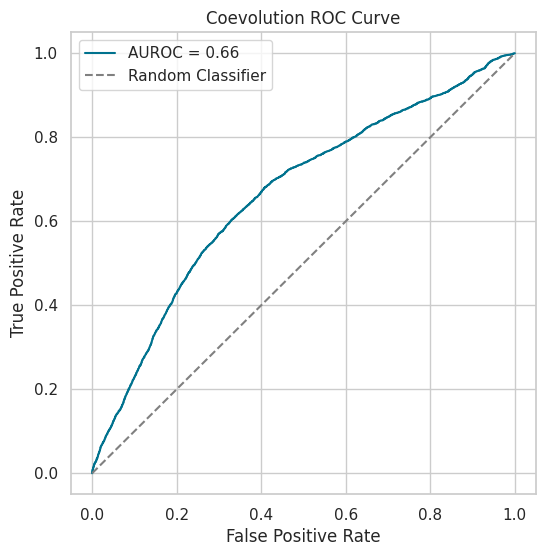

In [36]:
plt.figure(figsize=(6, 6))
plt.plot(coev_fpr, coev_tpr, label=f'AUROC = {coev_auroc:.2f}', color=ncolor)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Coevolution ROC Curve')
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()

In [37]:
import numpy as np
from scipy.interpolate import interp1d

def interpolate_data(x_data, y_data, new_x):
    """
    Interpolate y_data to match new_x using linear interpolation.

    Parameters:
    x_data : array-like
        The original x data points.
    y_data : array-like
        The original y data points corresponding to x_data.
    new_x : array-like
        The new x data points for which we want to compute interpolated y values.

    Returns:
    new_x : array-like
        The input new_x values (unchanged).
    new_y : array-like
        The interpolated y values corresponding to new_x.
    """
    # Create an interpolation function
    interpolation_func = interp1d(x_data, y_data, kind='linear', fill_value="extrapolate")
    
    # Compute new_y by applying the interpolation function to new_x
    new_y = interpolation_func(new_x)
    
    return new_x, new_y


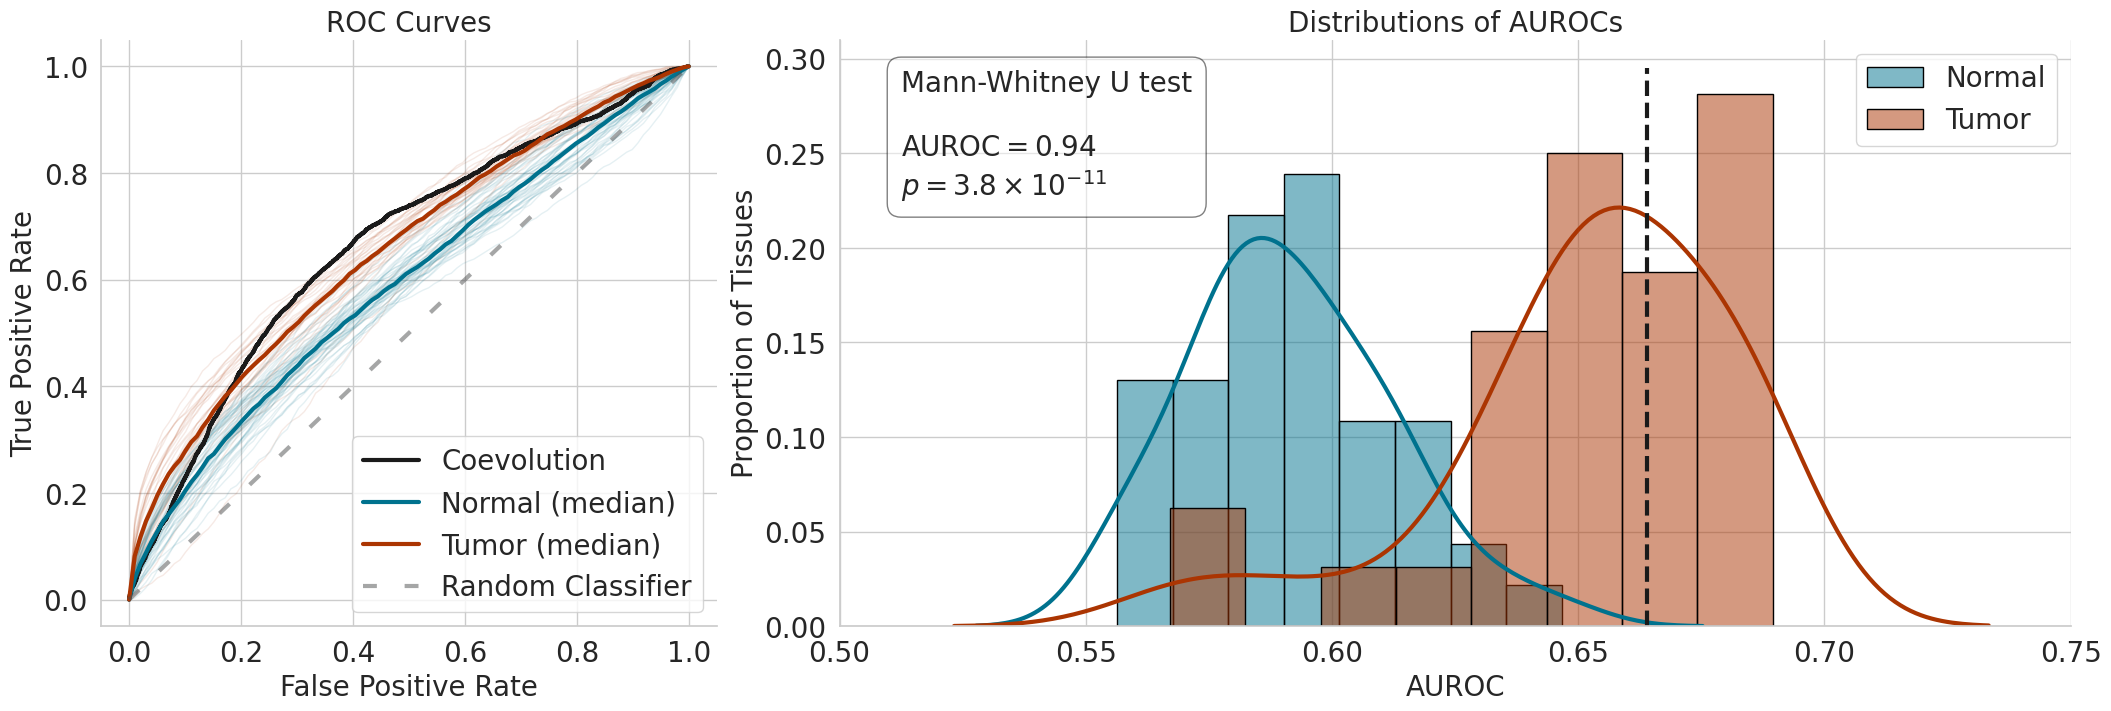

In [38]:
# Define font size
fs = 20

# Data Preparation for AUROC
col = 'interactions_auroc'
normal_data = df.loc[df.condition == 'normal', col]
tumor_data = df.loc[df.condition == 'tumor', col]

# Perform Mann-Whitney U test
u_statistic, mannwhitney_p_value = mannwhitneyu(tumor_data, normal_data, alternative='greater')

# Create the figure
fig = plt.figure(layout="constrained", figsize=(21, 7))

axs = fig.subplot_mosaic(
    """
    ABB
    """
)

lw = 3
cut = 3
alpha=0.5
bins=8


# ----- PLOT A (ROC) ------

xx = np.linspace(0,1,100)

path = '/home/lnemati/pathway_crosstalk/results/roc/tumor'
t_yy = []

for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    
    xx, yy = interpolate_data(fpr, tpr, xx)
    axs['A'].plot(xx, yy, color=tcolor, linestyle='-', lw=1, alpha=0.1)
    
    t_yy.append(yy)
    
t_median = np.median(np.array(t_yy), axis=0)

path = '/home/lnemati/pathway_crosstalk/results/roc/normal'
n_yy = []

for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    
    xx, yy = interpolate_data(fpr, tpr, xx)
    axs['A'].plot(xx, yy, color=ncolor, linestyle='-', lw=1, alpha=0.1)
    
    n_yy.append(yy)
    
n_median = np.median(np.array(n_yy), axis=0)

axs['A'].plot(coev_fpr, coev_tpr, label=f'Coevolution', color='k', lw=lw)
axs['A'].plot(xx, n_median, color=ncolor, label=f'Normal (median)', lw=lw)
axs['A'].plot(xx, t_median, color=tcolor, label=f'Tumor (median)', lw=lw)
axs['A'].plot(xx, xx, color=graycolor2, label=f'Random Classifier', linestyle=(0, (3.33, 6.66)), lw=lw)

# ----- PLOT B (COMPARISON) ------

# Plot histograms for AUROC with outlines
sns.histplot(
    normal_data,
    bins=bins,
    stat='proportion',
    kde=True,
    color=ncolor,
    edgecolor='black',
    label='Normal',
    alpha=alpha,
    kde_kws={'cut': cut},
    line_kws={'linewidth': lw, 'color': ncolor},
    ax=axs['B'],
    )
sns.histplot(
    tumor_data,
    bins=bins,
    stat='proportion',
    kde=True,
    color=tcolor,
    edgecolor='black',
    label='Tumor',
    alpha=alpha,
    kde_kws={'cut': cut},
    line_kws={'linewidth': lw, 'color': tcolor},
    ax=axs['B']
)

axs['A'].set_title('ROC Curves', fontsize=fs)
axs['A'].set_xlabel('False Positive Rate', fontsize=fs)
axs['A'].set_ylabel('True Positive Rate', fontsize=fs)
axs['A'].legend(fontsize=fs)
axs['A'].tick_params(axis='both', labelsize=fs)

axs['B'].set_title('Distributions of AUROCs', fontsize=fs)
axs['B'].set_xlabel('AUROC', fontsize=fs)
axs['B'].set_ylabel('Proportion of Tissues', fontsize=fs)
axs['B'].legend(fontsize=fs)
axs['B'].tick_params(axis='both', labelsize=fs)

# Add text box for Mann-Whitney U test results with transparency
u_str = str(int(u_statistic))
p_str = str(str(f"{mannwhitney_p_value:.1e}"))[:3] + '\\times 10^{' + str(mannwhitney_p_value).split('e')[-1] + '}'

auroc_t_vs_n = round(u_statistic / (tumor_data.shape[0] * normal_data.shape[0]), 2)

textstr = f"Mann-Whitney U test\n\nAUROC$={auroc_t_vs_n}$\n$p={p_str}$"
props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.5)
axs['B'].text(0.05, 0.95, textstr, transform=axs['B'].transAxes, fontsize=fs, verticalalignment='top', bbox=props)

axs['B'].set_xlim(0.5, 0.75)
#axs['B'].set_ylim(0, 15)

# Add vertical line for coevolution
ylim = axs['B'].get_ylim()[1]
axs['B'].vlines(x=coev_auroc,ymin=0, ymax=ylim, colors='k', linestyles='--', label='Coevolution', lw=3)

for ax in axs:
    axs[ax].spines[['right', 'top']].set_visible(False)
    axs[ax].tick_params(labelsize=fs)

#plt.tight_layout()

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_auroc_histogram.pdf', bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_auroc_histogram.png', bbox_inches='tight')

# Show the plot
plt.show()


In [39]:
#fig_to_panels(fig, axs, output_dir='/home/lnemati/pathway_crosstalk/results/figures/comparison/')

In [40]:
n_data = normal_data.to_frame()
n_data['Condition'] = 'Normal'
t_data = tumor_data.to_frame()
t_data['Condition'] = 'Tumor'
data = pd.concat([n_data, t_data])

/var/tmp/pbs.374199.pbs01/ipykernel_9416/4268813946.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='interactions_auroc', data=data, palette=[ncolor, tcolor], ax=axs['B'])


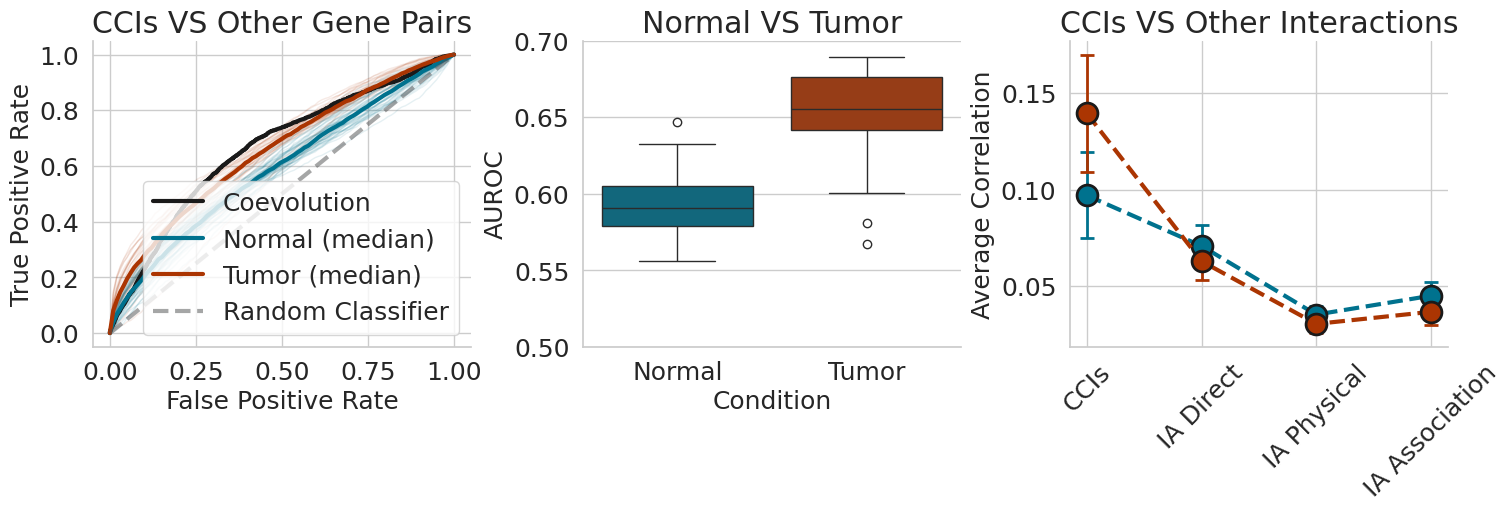

In [41]:
# Define font size
fs = 18

# Data Preparation for AUROC
col = 'interactions_auroc'
normal_data = df.loc[df.condition == 'normal', col]
tumor_data = df.loc[df.condition == 'tumor', col]

# Perform Mann-Whitney U test
u_statistic, mannwhitney_p_value = mannwhitneyu(tumor_data, normal_data, alternative='greater')

# Create the figure
fig = plt.figure(layout="constrained", figsize=(15, 5))

axs = fig.subplot_mosaic(
    """
    ABC
    """
)

lw = 3
cut = 3
alpha=0.5
bins=10


# ----- PLOT A (ROC) ------

xx = np.linspace(0,1,100)

path = '/home/lnemati/pathway_crosstalk/results/roc/tumor'
t_yy = []

for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    
    xx, yy = interpolate_data(fpr, tpr, xx)
    axs['A'].plot(xx, yy, color=tcolor, linestyle='-', lw=1, alpha=0.1)
    
    t_yy.append(yy)
    
t_median = np.median(np.array(t_yy), axis=0)

path = '/home/lnemati/pathway_crosstalk/results/roc/normal'
n_yy = []

for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    
    xx, yy = interpolate_data(fpr, tpr, xx)
    axs['A'].plot(xx, yy, color=ncolor, linestyle='-', lw=1, alpha=0.1)
    
    n_yy.append(yy)
    
n_median = np.median(np.array(n_yy), axis=0)

axs['A'].plot(coev_fpr, coev_tpr, label=f'Coevolution', color='k', lw=lw)
axs['A'].plot(xx, n_median, color=ncolor, label=f'Normal (median)', lw=lw)
axs['A'].plot(xx, t_median, color=tcolor, label=f'Tumor (median)', lw=lw)
axs['A'].plot(xx, xx, color=graycolor2, label=f'Random Classifier', lw=lw, linestyle='--')#(0, (3.33, 6.66)))

axs['A'].set_title('CCIs VS Other Gene Pairs', fontsize=1.2*fs)
axs['A'].set_xlabel('False Positive Rate', fontsize=fs)
axs['A'].set_ylabel('True Positive Rate', fontsize=fs)
axs['A'].legend(fontsize=fs)

# ----- PLOT B (TUMOR NORMAL COMPARISON) ------

sns.boxplot(x='Condition', y='interactions_auroc', data=data, palette=[ncolor, tcolor], ax=axs['B'])
axs['B'].set_title('Normal VS Tumor', fontsize=1.2*fs)
axs['B'].set_xlabel('Condition', fontsize=fs)
axs['B'].set_ylabel('AUROC', fontsize=fs)
axs['B'].set_ylim(0.5, 0.7)
axs['B'].set_yticks([0.5, 0.55, 0.6, 0.65, 0.7])

# ----- PLOT C (EXTRACELLULAR VS INTRACELLULAR) ------

# Read and filter the data
df2 = pd.read_csv('/home/lnemati/pathway_crosstalk/results/comparison/averages.csv')
#df2[df2['subtissue'] != 'testis']

df2['interaction_type'] = df2['interaction_type'].replace({
    'ccc_lr_pairs.csv': 'Cell-Cell Communication', 
    'intact_direct.csv': 'IntAct Direct',
    'intact_association.csv': 'IntAct Association',
    'intact_physical.csv': 'IntAct Physical'
})


df2 = df2.groupby(['condition', 'major_tissue', 'interaction_type', 'value_type'])['value'].mean().to_frame().reset_index()
df2 = df2.query('value_type == "average_corr"')

# Group by interaction type and condition, calculate mean and standard deviation
meandf = df2.groupby(['interaction_type', 'condition'])['value'].mean().to_frame().reset_index()
meandf['interaction_type'] = meandf['interaction_type'].apply(lambda x: x.replace('.csv', ''))

stddf = df2.groupby(['interaction_type', 'condition'])['value'].std().to_frame().reset_index()
stddf['interaction_type'] = stddf['interaction_type'].apply(lambda x: x.replace('.csv', ''))

# Define the order and align the data
order = ['Cell-Cell Communication', 'IntAct Direct', 'IntAct Physical', 'IntAct Association']
meandf = meandf.set_index('interaction_type').loc[order]
stddf = stddf.set_index('interaction_type').loc[order]

# Define the style and colors
style_normal = dict(marker='o', linestyle='--', markersize=15, linewidth=lw, markeredgewidth=2,
                    markerfacecolor=ncolor, markeredgecolor='k', color=ncolor)
style_tumor = dict(marker='o', linestyle='--', markersize=15, linewidth=lw, markeredgewidth=2,
                   markerfacecolor=tcolor, markeredgecolor='k', color=tcolor)

# Error bar customization
errorbar_kwargs = {
    'capsize': 5,
    'elinewidth': 2,
    'capthick': 2,
}

# Extract means and standard deviations
normal_means = meandf.query('condition == "normal"')['value']
normal_stds = stddf.query('condition == "normal"')['value']
tumor_means = meandf.query('condition == "tumor"')['value']
tumor_stds = stddf.query('condition == "tumor"')['value']

# Plot with error bars
axs['C'].errorbar(x=range(len(normal_means)), y=normal_means, yerr=normal_stds,
             label="Normal", **style_normal, **errorbar_kwargs)
axs['C'].errorbar(x=range(len(tumor_means)), y=tumor_means, yerr=tumor_stds,
             label="Tumor", **style_tumor, **errorbar_kwargs)

axs['C'].set_title('CCIs VS Other Interactions', fontsize=1.2*fs)
axs['C'].set_ylabel('Average Correlation', fontsize=fs)
labels = pd.Series(order).map({'Cell-Cell Communication': 'CCIs', 'IntAct Direct': 'IA Direct', 'IntAct Physical': 'IA Physical', 'IntAct Association': 'IA Association'})
axs['C'].set_xticks(range(len(order)), labels, rotation=45)

for ax in axs:
    axs[ax].spines[['right', 'top']].set_visible(False)
    axs[ax].tick_params(labelsize=fs)

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/ccc_coexpr_new.pdf')#, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/ccc_coexpr_new.png')#, bbox_inches='tight')

# Show the plot
plt.show()


In [42]:
#fig_to_panels(fig, axs, output_dir='/home/lnemati/pathway_crosstalk/results/figures/comparison/')

In [43]:
del all_pairs

In [44]:
UPDATE_COEV = False

if UPDATE_COEV:

    coev = pd.read_csv('/home/lnemati/resources/coevolution/jaccard_genes.csv.gz', index_col=0)

    files = [
        'ccc_lr_pairs.csv',
        'intact_direct.csv',
        'intact_physical.csv',
        'intact_association.csv',
    ]

    coev_means = {}
    coev_stds   = {}

    for name, file in zip(['CCIs', 'IA Direct', 'IA Physical', 'IA Association'], files):
        print(name)
        df = pd.read_csv(os.path.join('/home/lnemati/pathway_crosstalk/data/interactions', file))
        df.all_genes = df.all_genes.apply(ast.literal_eval)

        genes = set(df.all_genes.sum())
        genes = list(genes.intersection(coev.index))

        mask = df.all_genes.apply(lambda x: all([gene in genes for gene in x])) # interactions with both genes present

        pairs = pd.Index(df.loc[mask, 'all_genes'].apply(tuple).values)

        subset = coev.loc[genes, genes].stack()

        mean = subset.loc[pairs].mean()
        std  = subset.loc[pairs].std()

        coev_means[name] = mean
        coev_stds[name] = std

        print(mean, std)

        df2 = pd.read_csv('/home/lnemati/pathway_crosstalk/results/comparison/averages.csv')

        means = pd.Series(coev_means)
        means.name = 'value'
        means = means.to_frame().reset_index(drop=False)
        means = means.rename(columns = {'index': 'interaction_type'})
        means['interaction_type'] = means['interaction_type']
        means['condition'] = 'coevolution'
        means['major_tissue'] = np.nan
        means['value_type'] = 'jaccard'

        df_with_coev = pd.concat([df2, means]).reset_index()
        df_with_coev.to_csv('/home/lnemati/pathway_crosstalk/results/comparison/averages_with_coev.csv')

else:
    df2 = pd.read_csv('/home/lnemati/pathway_crosstalk/results/comparison/averages.csv')
    df2 = df2.query('value_type == "average_corr"')

    df_with_coev = pd.read_csv('/home/lnemati/pathway_crosstalk/results/comparison/averages_with_coev.csv', index_col=0)
    df_with_coev = df_with_coev.drop(columns=['index'])
    df_with_coev = df_with_coev.query('value_type == "jaccard"')

    df_with_coev = pd.concat([df2, df_with_coev])


In [45]:
df_with_coev['interaction_type'] = df_with_coev.interaction_type.replace({
    'Cell-Cell Communication': 'CCIs',
    'IntAct Direct': 'IA Direct',
    'IntAct Physical': 'IA Physical',
    'IntAct Association': 'IA Association',    
    'ccc_lr_pairs.csv': 'CCIs',
    'intact_direct.csv': 'IA Direct',
    'intact_physical.csv': 'IA Physical',
    'intact_association.csv': 'IA Association',
})


In [46]:
df2 = df_with_coev

In [47]:
#coev_means = means
#stds_stds = stds

In [48]:
t_df = df2.query('value_type == "average_corr" and condition == "tumor"')
ccc = t_df.loc[t_df.interaction_type == 'CCIs', 'value']
direct = t_df.loc[t_df.interaction_type == 'IA Direct', 'value']
mannwhitneyu(ccc, direct)

MannwhitneyuResult(statistic=1021.0, pvalue=8.628212667494317e-12)

In [49]:
n_df = df2.query('value_type == "average_corr" and condition == "normal"')
ccc = n_df.loc[n_df.interaction_type == 'CCIs', 'value']
direct = n_df.loc[n_df.interaction_type == 'IA Direct', 'value']
mannwhitneyu(ccc, direct)

MannwhitneyuResult(statistic=1871.0, pvalue=2.2278328719953532e-10)

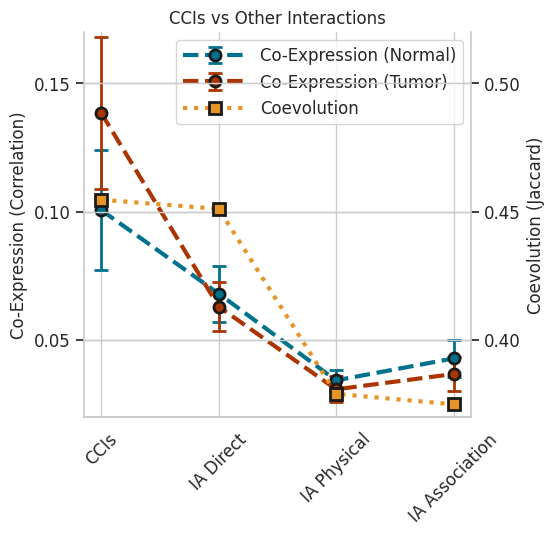

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

lw = 3  # Line width
fs = 12  # Font size

# Create the figure
fig, ax1 = plt.subplots(figsize=(5, 5))
ax2 = ax1.twinx()  # Create a second y-axis

df2 = df_with_coev.groupby(['condition', 'major_tissue', 'interaction_type', 'value_type'])['value'].mean().reset_index()
df2 = df_with_coev.query('value_type == "average_corr" or value_type == "coevolution"')

# Group by interaction type and condition, calculate mean and standard deviation
meandf = df_with_coev.groupby(['interaction_type', 'condition'])['value'].mean().reset_index()
stddf = df_with_coev.groupby(['interaction_type', 'condition'])['value'].std().reset_index()

# Define the order and align the data
order = ['CCIs', 'IA Direct', 'IA Physical', 'IA Association']
meandf = meandf.set_index('interaction_type').loc[order]
stddf = stddf.set_index('interaction_type').loc[order]

# Extract means and standard deviations
normal_means = meandf.query('condition == "normal"')['value']
normal_stds = stddf.query('condition == "normal"')['value']
tumor_means = meandf.query('condition == "tumor"')['value']
tumor_stds = stddf.query('condition == "tumor"')['value']

# Define styles
style_normal = dict(marker='o', linestyle='--', markersize=8, linewidth=lw, markeredgewidth=2,
                    markerfacecolor=ncolor, markeredgecolor='k', color=ncolor)
style_tumor = dict(marker='o', linestyle='--', markersize=8, linewidth=lw, markeredgewidth=2,
                   markerfacecolor=tcolor, markeredgecolor='k', color=tcolor)
style_coev = dict(marker='s', linestyle=':', markersize=8, linewidth=lw, markeredgewidth=2,
                   markerfacecolor=orangecolor, markeredgecolor='k', color=orangecolor)

errorbar_kwargs = {'capsize': 5, 'elinewidth': 2, 'capthick': 2}

# Plot coevolution on ax2 first to keep it in the background
coev_means = df_with_coev.query('value_type == "jaccard"').set_index('interaction_type').loc[order].value
coev_plot = ax2.errorbar(x=[0,1,2,3], y=list(coev_means.values), label="Coevolution", **style_coev)

# Plot correlation on ax1 after to ensure it is in the foreground
normal_plot = ax1.errorbar(x=range(len(normal_means)), y=normal_means, yerr=normal_stds, label="Co-Expression (Normal)", **style_normal, **errorbar_kwargs)
tumor_plot = ax1.errorbar(x=range(len(tumor_means)), y=tumor_means, yerr=tumor_stds, label="Co-Expression (Tumor)", **style_tumor, **errorbar_kwargs)

# Labels and titles
ax1.set_ylabel('Co-Expression (Correlation)', fontsize=fs)
ax2.set_ylabel('Coevolution (Jaccard)', fontsize=fs)
ax1.set_xticks(range(len(order)))
ax1.set_xticklabels(order, rotation=45, fontsize=fs)
ax1.set_ylim(0.02, 0.17)
ax2.set_ylim(0.37, 0.52)
ax1.set_title('CCIs vs Other Interactions', fontsize=fs)

ax1.tick_params(labelsize=fs)
ax2.tick_params(labelsize=fs)

ax1.set_yticks([0.05, 0.1, 0.15])
ax2.set_yticks([0.4, 0.45, 0.5])

# Hide unnecessary spines
ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['left', 'top']].set_visible(False)

# Create combined legend to ensure correct linestyles
handles = [normal_plot, tumor_plot, coev_plot]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper right', fontsize=fs, handlelength=3.8)

# Save the figure
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/ccs_vs_intracellular.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/ccs_vs_intracellular.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


# Modules tot.

In [51]:
# Define the base directory where the search should start
base_dir = '/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal'

# Search for all files named 'ccc.csv' in subdirectories
all_paths = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file == 'ccc.csv':
            all_paths.append(os.path.join(root, file))

# Initialize an empty list to hold DataFrames
dfs = []

# Process each file and extract relevant columns
for path in all_paths:
    # Extract the tissue type from the directory structure
    tissue = os.path.basename(os.path.dirname(os.path.dirname(path)))  # Parent folder of 'interactions'
    
    # Read the CSV file and extract required columns
    smdf = pd.read_csv(path, index_col='interaction', usecols=['interaction', 'same_module'])
    smdf.rename(columns={'same_module': tissue}, inplace=True)
    dfs.append(smdf)

# Combine all DataFrames along the column axis
same_module = pd.concat(dfs, axis=1)

In [52]:
tissues_df = pd.read_csv('/home/lnemati/pathway_crosstalk/data/tissues.csv', index_col='subtissue')
tissues_df = tissues_df[tissues_df.index != 'testis']

In [53]:
same_module_subtissues = same_module.T
same_module_subtissues.index.name = 'subtissue'

In [54]:
same_module_subtissues.insert(0, 'tissue', tissues_df.loc[same_module_subtissues.index, 'tissue'])
same_module_subtissues.insert(1, 'condition', tissues_df.loc[same_module_subtissues.index, 'condition'])

In [55]:
#same_module_subtissues.to_csv('/home/lnemati/pathway_crosstalk/results/interactions_network/same_module_interactions_all_subtissues.csv')

In [56]:
# Move from subtissues to tissue by averaging
same_module_tissues = same_module_subtissues.groupby(['tissue', 'condition']).mean()

In [57]:
t_tissues = same_module_tissues.reset_index().condition.value_counts()['tumor']
n_tissues = same_module_tissues.reset_index().condition.value_counts()['normal']

In [58]:
tfrac = same_module_tissues.query('condition == "tumor"').mean()
tfrac.name = 'tumor_fraction'
nfrac = same_module_tissues.query('condition == "normal"').mean()
nfrac.name = 'normal_fraction'

In [59]:
same_module_fraction = tfrac.to_frame().join(nfrac)
same_module_fraction = same_module_fraction.loc[same_module_fraction.eval('normal_fraction - tumor_fraction').sort_values().index]
#same_module_fraction.to_csv('/home/lnemati/pathway_crosstalk/results/interactions_network/same_module_interactions_aggregate_tissues.csv')

/var/tmp/pbs.374199.pbs01/ipykernel_9416/2525729987.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{abs(x):.1f}' for x in ax.get_xticks()])


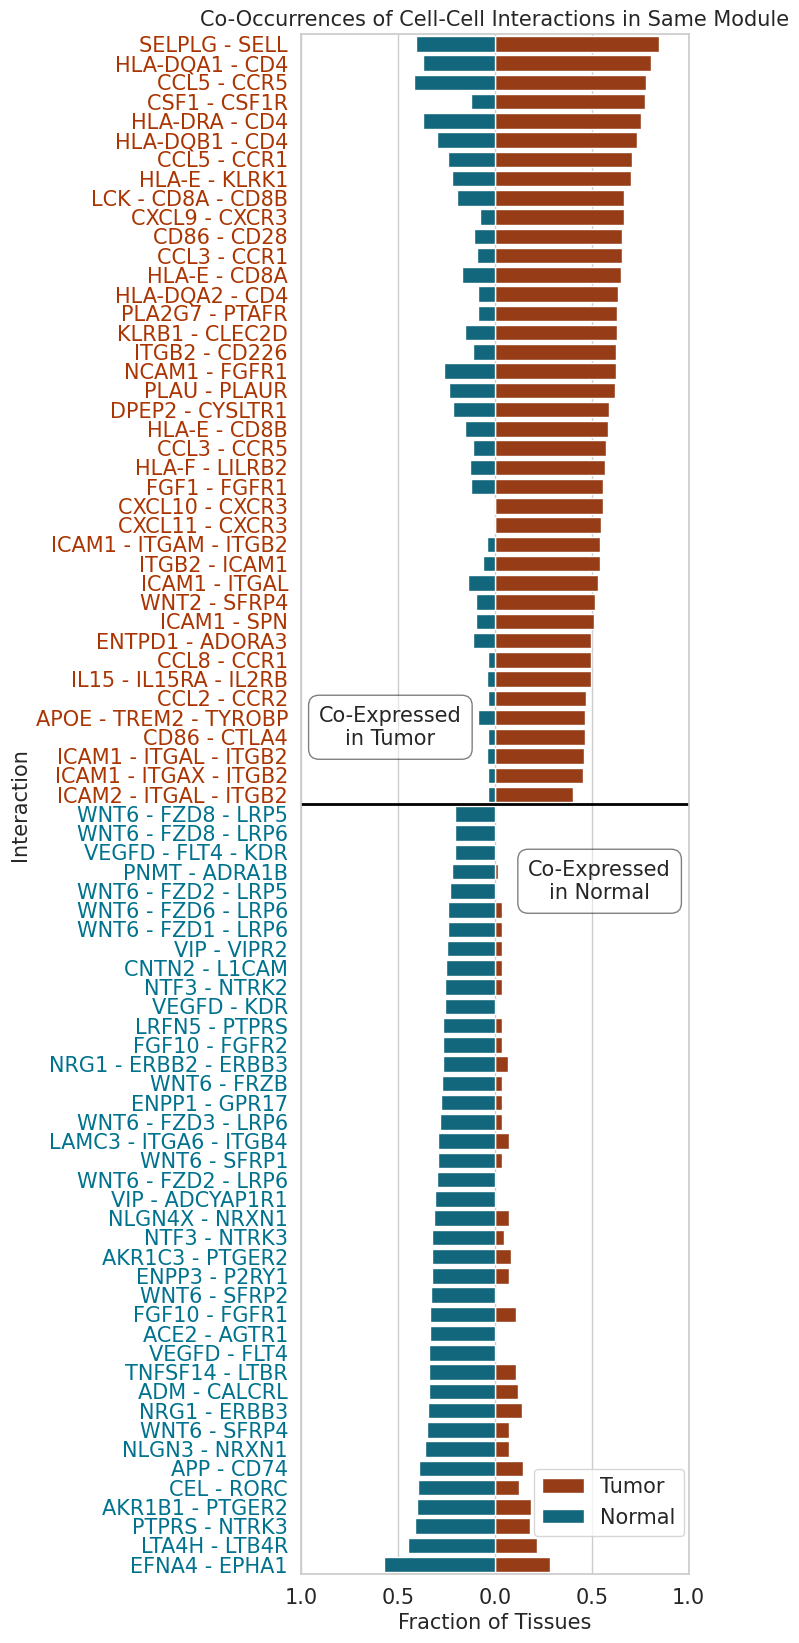

In [60]:
import matplotlib.patheffects as path_effects

N = 40
fs = 15
smdf = pd.concat([
    same_module_fraction.head(N).sort_values(by='tumor_fraction')[::-1],
    same_module_fraction.tail(N).sort_values(by='normal_fraction')
])

smdf['normal_fraction'] *= -1
smdf.index = smdf.index.str.replace('_', ' - ').str.replace('+', ' - ')

fig, ax = plt.subplots(1, 1, figsize=(5, 20), sharey=True)
plt.subplots_adjust(wspace=0)

sns.barplot(ax=ax, y='interaction', x='tumor_fraction', data=smdf, color=tcolor, alpha=1, label='Tumor')
sns.barplot(ax=ax, y='interaction', x='normal_fraction', data=smdf, color=ncolor, alpha=1, label='Normal')

#ax1.axhline(0, color='black', linewidth=3, linestyle='-')
#ax2.axhline(0, color='black', linewidth=3, linestyle='-')

xlim1, xlim2 = ax.get_xlim()
ax.axhline(N-0.5, color='black', linewidth=2, linestyle='-')

# Adding labels and title for subplot 2
ax.set_xlabel('Fraction of Tissues', fontsize=fs)
ax.set_ylabel('Interaction', fontsize=fs)
ax.tick_params(labelsize=fs)
ax.set_title('Co-Occurrences of Cell-Cell Interactions in Same Module', fontsize=fs)

props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.5)
text = ax.text(0.23, 0.55, 'Co-Expressed\nin Tumor', horizontalalignment='center', verticalalignment='center', fontsize=fs, transform=ax.transAxes, bbox=props)
#text.set_path_effects([
#    path_effects.Stroke(linewidth=10, foreground='white'),  # White outline
#    path_effects.Normal()  # Regular text
#])

props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.5)
text = ax.text(0.77, 0.45, 'Co-Expressed\nin Normal', horizontalalignment='center', verticalalignment='center', fontsize=fs, transform=ax.transAxes, bbox=props)
#text.set_path_effects([
#    path_effects.Stroke(linewidth=10, foreground='white'),  # White outline
#    path_effects.Normal()  # Regular text
#])

ax.legend(fontsize=fs, loc=(0.60, 0.025))

#ax.tick_params(axis='x', rotation=90)

ax.set_xlim(-1, 1)
# Change negative y-axis ticks to positive and display only the first decimal place
ax.set_xticklabels([f'{abs(x):.1f}' for x in ax.get_xticks()])

# Tick label colors
y_labels = ax.get_yticklabels()
for i, label in enumerate(y_labels):
    if i < N:  # First N interactions
        label.set_color(tcolor)
    else:  # Last N interactions
        label.set_color(ncolor)

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/same_module.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/same_module.svg', bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/same_module.png', bbox_inches='tight')

plt.show()

# Tumor Coevolution - COSMIC

In [61]:
df_complete = pd.read_csv('/projects/bioinformatics/DB/CancerTracer/intra_heterogeneity_data.txt', sep='\t')

# Remove wrongly formatted row
df_complete = df_complete[~df_complete.index.isin(['p075_p3'])]

In [62]:
import re
import pandas as pd

def extract_mutation_info(mutation_string, allowed_strings=None):
    # Return empty lists if the input string is missing or empty
    if pd.isna(mutation_string) or mutation_string == '':
        return [], [], []

    # Split the string into individual entries
    gene_entries = mutation_string.split(',')
    
    if allowed_strings is None:
        filtered_entries = [entry for entry in gene_entries]
    else:
    # Filter entries that have allowed patterns and contain a closing parenthesis
        filtered_entries = [entry for entry in gene_entries if any([x in entry for x in allowed_strings]) and ')' in entry]

    # Initialize lists to store genes, mutations, and samples
    genes = []
    mutations = []
    samples = []

    # Process each filtered entry
    for entry in filtered_entries:
        # Get gene: Keep only the text before the first set of parentheses
        gene = re.sub(r'\s*\(.*$', '', entry).strip()

        # Get mutation: Extract the content inside the parentheses
        mutation_match = re.search(r'\(([^()]*)\)', entry)
        mutation = mutation_match.group(1).strip() if mutation_match else ''

        # Get sample: Keep only the text after the first set of parentheses
        sample_match = re.search(r'\(.*?\)\s*([- ]*)(.*)', entry)
        sample = sample_match.group(2).strip('- ').strip() if sample_match else ''

        # Append the parsed components to respective lists
        genes.append(gene)
        mutations.append(mutation)
        samples.append(sample)

    # Return the lists of genes, mutations, and samples
    return genes, mutations, samples


In [63]:
dfs = []

for col in ['Trunk_mutation', 'Branch_mutation', 'Private_mutation']:
    # Separate individual mutations
    # Use regex to split only on commas that are not inside parentheses
    vals = df_complete[col].str.split(r',\s*(?![^(]*\))', expand=True)
    
    # Find nans
    keep = ~vals.isna()
    
    # Add sample ids
    samples = df_complete['Sample']
    samples.index = samples.values
    vals.index = samples.values
    vals = (vals.T.astype(str) + samples).T
    
    # Remove nans
    vals = vals.values[keep]

    allowed_strings = ['(p.', '(amp', '(del']
    #allowed_strings = None
    
    genes, mutations, samples = extract_mutation_info(", ".join(vals), allowed_strings = allowed_strings)
    
    #genes     = [get_gene(x)     for x in vals]
    #mutations = [get_mutation(x) for x in vals]
    #samples   = [get_sample(x)   for x in vals]
    
    mutationsdf = pd.DataFrame()
    mutationsdf.index = genes
    mutationsdf['mutation'] = mutations
    mutationsdf['patient'] = samples
    mutationsdf['when'] = col.strip('_mutation')
    
    dfs.append(mutationsdf)
    
mutationsdf = pd.concat(dfs)
#mutationsdf['when'] = mutationsdf['when'].map({'Trunk': 'Trunk', 'Private': 'Branch/Private', 'Branch': 'Branch/Private'})
mutationsdf['gene'] = mutationsdf.index

mutationsdf = mutationsdf[~mutationsdf.index.isin(['', ' ', '-'])]
mutationsdf = mutationsdf[~mutationsdf['patient'].isin(['', ' ', '-'])]
mutationsdf = mutationsdf[~mutationsdf['gene'].isin(['', ' ', '-'])]


In [64]:
cosmic = pd.read_csv('/projects/bioinformatics/DB/COSMIC/Census_2024.tsv', sep='\t')
cosmic = set(cosmic['Gene Symbol'].unique())

In [65]:
lr = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz_all_pairs.csv')
lr_pairs = lr.apply(lambda x: [x.ligand, x.receptor], axis=1)
lr = set(lr['ligand']).union(lr['receptor'])

In [66]:
# LR pairs where at least one gene is in cosmic
# I don't know how to use these yet

#cosmic_lr_pairs = lr_pairs[lr_pairs.apply(lambda x: any([gene in cosmic for gene in x]))].reset_index(drop=True)
#cosmic_lr_pairs

In [67]:
mutationsdf['cosmic'] = False
mutationsdf['ccc'] = False

mutationsdf.loc[mutationsdf.gene.isin(cosmic), 'cosmic'] = True
mutationsdf.loc[mutationsdf.gene.isin(lr), 'ccc'] = True

In [68]:
mutationsdf = mutationsdf[mutationsdf.cosmic]

In [69]:
mutationsdf.index = (mutationsdf['patient'] + '_' + mutationsdf['gene'])
mutationsdf['unique_id'] = (mutationsdf['patient'] + '_' + mutationsdf['gene'])

In [70]:
counts = mutationsdf.groupby(['unique_id', 'when']).size().reset_index(name='count')
counts = counts.sort_values(by='count', ascending=False)
counts['patient'] = counts['unique_id'].str.split('_').apply(lambda x: '_'.join(x[:-1]))
counts['gene'] = counts['unique_id'].str.split('_').apply(lambda x: '_'.join(x[-1:]))

counts['ccc'] = False
counts.loc[counts.gene.isin(lr), 'ccc'] = True

In [71]:
genes = counts.groupby(['gene', 'when'])['count'].sum().to_frame()

In [72]:
genes['gene'] = genes.index.get_level_values(0)
genes['when'] = genes.index.get_level_values(1)
genes.index = range(len(genes))

In [73]:
# Group by 'gene' and calculate the total counts for each gene
total_counts = genes.groupby('gene')['count'].sum()

# Sort genes by total count in descending order
genes = genes.set_index('gene').loc[total_counts.sort_values(ascending=False).index].reset_index()

In [74]:
## Init mutationsdfdf for test results
results = pd.DataFrame(columns=['auroc', 'pval'])

genes_pivot = genes.pivot(index='gene', columns='when', values='count').fillna(0)
genes_pivot = genes_pivot.loc[total_counts.sort_values(ascending=False).index]

genes_pivot_ccc = genes_pivot.loc[genes_pivot.index.isin(lr)]
genes_pivot_not_ccc = genes_pivot.loc[~genes_pivot.index.isin(lr)]

# Calculate log10 of Total values for CCC and Other Genes
total_ccc_log10 = np.log10(genes_pivot_ccc.sum(axis=1))
total_not_ccc_log10 = np.log10(genes_pivot_not_ccc.sum(axis=1))

# Perform Mann-Whitney U test on log10 transformed Total values
result = mannwhitneyu(total_ccc_log10, total_not_ccc_log10)

# Store AUROC and p-value for log10 Total
results.loc['log10 Total', 'auroc'] = result.statistic / (total_ccc_log10.shape[0] * total_not_ccc_log10.shape[0])
results.loc['log10 Total', 'pval'] = result.pvalue

# Normalize Trunk, Branch, and Private by Total for CCC and Other Genes
genes_ccc_norm = genes_pivot_ccc.T.div(genes_pivot_ccc.sum(axis=1)).T
genes_not_ccc_norm = genes_pivot_not_ccc.T.div(genes_pivot_not_ccc.sum(axis=1)).T

# Perform comparisons for Trunk, Branch, and Private
for col in genes_pivot.columns:
    result = mannwhitneyu(genes_ccc_norm[col], genes_not_ccc_norm[col])
    results.loc[col, 'auroc'] = result.statistic / (genes_ccc_norm.shape[0] * genes_not_ccc_norm.shape[0])
    results.loc[col, 'pval'] = result.pvalue
    
# Apply multiple testing correction
results['pval_adj'] = false_discovery_control(results.pval.astype(float).values)

results = results.loc[['log10 Total', 'Trunk', 'Branch', 'Private']]
#results.to_csv('/home/lnemati/pathway_crosstalk/results/coevolution/cosmic/test_results.csv')

In [75]:
results

,auroc,pval,pval_adj
log10 Total,0.601071,0.001729,0.003458
Trunk,0.602179,0.001395,0.003458
Branch,0.443823,0.076226,0.101635
Private,0.448203,0.10809,0.108090


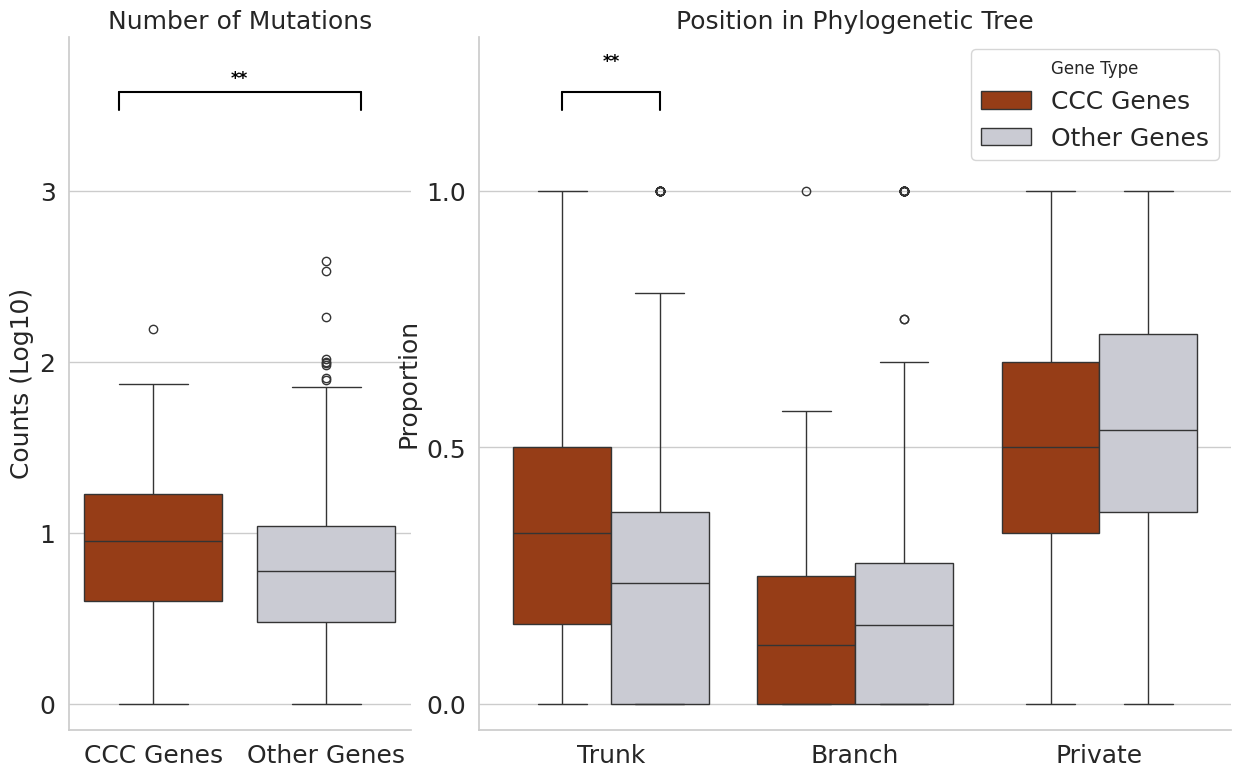

In [76]:
# Boxplots

fs=18

fig, ax = plt.subplot_mosaic(
    '''
    ABB
    ''',
    figsize=(15,9)
)

# Melt data for plotting
data = pd.DataFrame({
    'Comparison': (['log10 Total'] * len(total_ccc_log10) + ['log10 Total'] * len(total_not_ccc_log10) +
                   ['Trunk'] * len(genes_ccc_norm['Trunk']) + ['Trunk'] * len(genes_not_ccc_norm['Trunk']) +
                   ['Branch'] * len(genes_ccc_norm['Branch']) + ['Branch'] * len(genes_not_ccc_norm['Branch']) +
                   ['Private'] * len(genes_ccc_norm['Private']) + ['Private'] * len(genes_not_ccc_norm['Private'])),
    'Gene Type': (['CCC Genes'] * len(total_ccc_log10) + ['Other Genes'] * len(total_not_ccc_log10) +
                  ['CCC Genes'] * len(genes_ccc_norm['Trunk']) + ['Other Genes'] * len(genes_not_ccc_norm['Trunk']) +
                  ['CCC Genes'] * len(genes_ccc_norm['Branch']) + ['Other Genes'] * len(genes_not_ccc_norm['Branch']) +
                  ['CCC Genes'] * len(genes_ccc_norm['Private']) + ['Other Genes'] * len(genes_not_ccc_norm['Private'])),
    'Value': np.concatenate([total_ccc_log10, total_not_ccc_log10,
                             genes_ccc_norm['Trunk'], genes_not_ccc_norm['Trunk'],
                             genes_ccc_norm['Branch'], genes_not_ccc_norm['Branch'],
                             genes_ccc_norm['Private'], genes_not_ccc_norm['Private']])
})

counts = data.query('Comparison == "log10 Total"')
fracs = data.query('Comparison != "log10 Total"')

# Total counts
sns.boxplot(
    x='Gene Type',
    y='Value',
    hue='Gene Type',
    data=counts,
    palette={'CCC Genes': tcolor, 'Other Genes': lightgray},
    ax=ax['A']
)

# Trunk, Brach, Private
sns.boxplot(
    x='Comparison',
    y='Value',
    hue='Gene Type',
    data=fracs,
    palette={'CCC Genes': tcolor, 'Other Genes': lightgray},
    ax=ax['B']
)
  
ax['A'].set_title('Number of Mutations', fontsize=fs)
#ax['A'].set_xlabel("Gene Type")
ax['A'].set_xlabel("", fontsize=fs)
ax['A'].set_ylabel("Counts (Log10)", fontsize=fs)
ax['A'].set_ylim(-0.15,3.9)
ax['A'].set_yticks([0,1,2,3])

ax['B'].set_title('Position in Phylogenetic Tree', fontsize=fs)
#ax['B'].set_xlabel("Phylogenetic Tree Position")
ax['B'].set_xlabel("", fontsize=fs)
ax['B'].set_ylabel("Proportion", fontsize=fs)
ax['B'].set_ylim(-0.05,1.3)
ax['B'].set_yticks([0,0.5,1])

for key in ax:
    ax[key].spines[['right', 'top']].set_visible(False)
    ax[key].tick_params(labelsize=fs)
    
# Add significance bars
for i, (comparison, row) in enumerate(results.iterrows()):
    if comparison == "log10 Total":
        which_ax = ax['A']
        x_positions = [0, 1]  # Positions of 'CCC Genes' and 'Other Genes'
    else:
        which_ax = ax['B']
        x_positions = [i - 1]  # Positions corresponding to 'Trunk', 'Branch', 'Private'

    if row['pval_adj'] < 0.05:
        lims = which_ax.get_ylim()
        yrange = lims[1] - lims[0]
        y = lims[0] + 0.92 * yrange  # Position of the horizontal bar

        if which_ax == ax['A']:
            # Horizontal line between 'CCC Genes' and 'Other Genes'
            which_ax.plot([x_positions[0] - 0.2, x_positions[1] + 0.2], [y, y], color='black')
            # Vertical segments
            which_ax.plot([x_positions[0] - 0.2, x_positions[0] - 0.2], [y - 0.025 * yrange, y], color='black')
            which_ax.plot([x_positions[1] + 0.2, x_positions[1] + 0.2], [y - 0.025 * yrange, y], color='black')
            # Significance stars at the midpoint
            which_ax.text(0.5, y + 0.05, '*' * (1 + (row['pval_adj'] < 0.01) + (row['pval_adj'] < 0.001)),
                          ha='center', color='black', weight='bold')
        else:
            # Horizontal line above the single category
            which_ax.plot([x_positions[0] - 0.2, x_positions[0] + 0.2], [y, y], color='black')
            # Vertical segments
            which_ax.plot([x_positions[0] - 0.2, x_positions[0] - 0.2], [y - 0.025 * yrange, y], color='black')
            which_ax.plot([x_positions[0] + 0.2, x_positions[0] + 0.2], [y - 0.025 * yrange, y], color='black')
            # Significance stars directly above
            which_ax.text(x_positions[0], y + 0.05, '*' * (1 + (row['pval_adj'] < 0.01) + (row['pval_adj'] < 0.001)),
                          ha='center', color='black', weight='bold')

ax['B'].legend(title='Gene Type', fontsize=fs)

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/tumor_coev/boxplots.pdf', bbox_inches='tight')
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/tumor_coev/boxplots.png', bbox_inches='tight')

plt.show()

In [77]:
time_ccc = genes_ccc_norm.eval('Private - Trunk') / genes_ccc_norm.sum(1)
time_not_ccc = genes_not_ccc_norm.eval('Private - Trunk') / genes_not_ccc_norm.sum(1)

# FULL FIGURE

In [78]:
a4_width = 8.27
a4y_height = 11.69

/var/tmp/pbs.374199.pbs01/ipykernel_9416/2301923597.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax2,
/var/tmp/pbs.374199.pbs01/ipykernel_9416/2301923597.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([label.get_text().capitalize() for label in ax2.get_xticklabels()])
/var/tmp/pbs.374199.pbs01/ipykernel_9416/2301923597.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{abs(x):.1f}' for x in ax.get_xticks()])


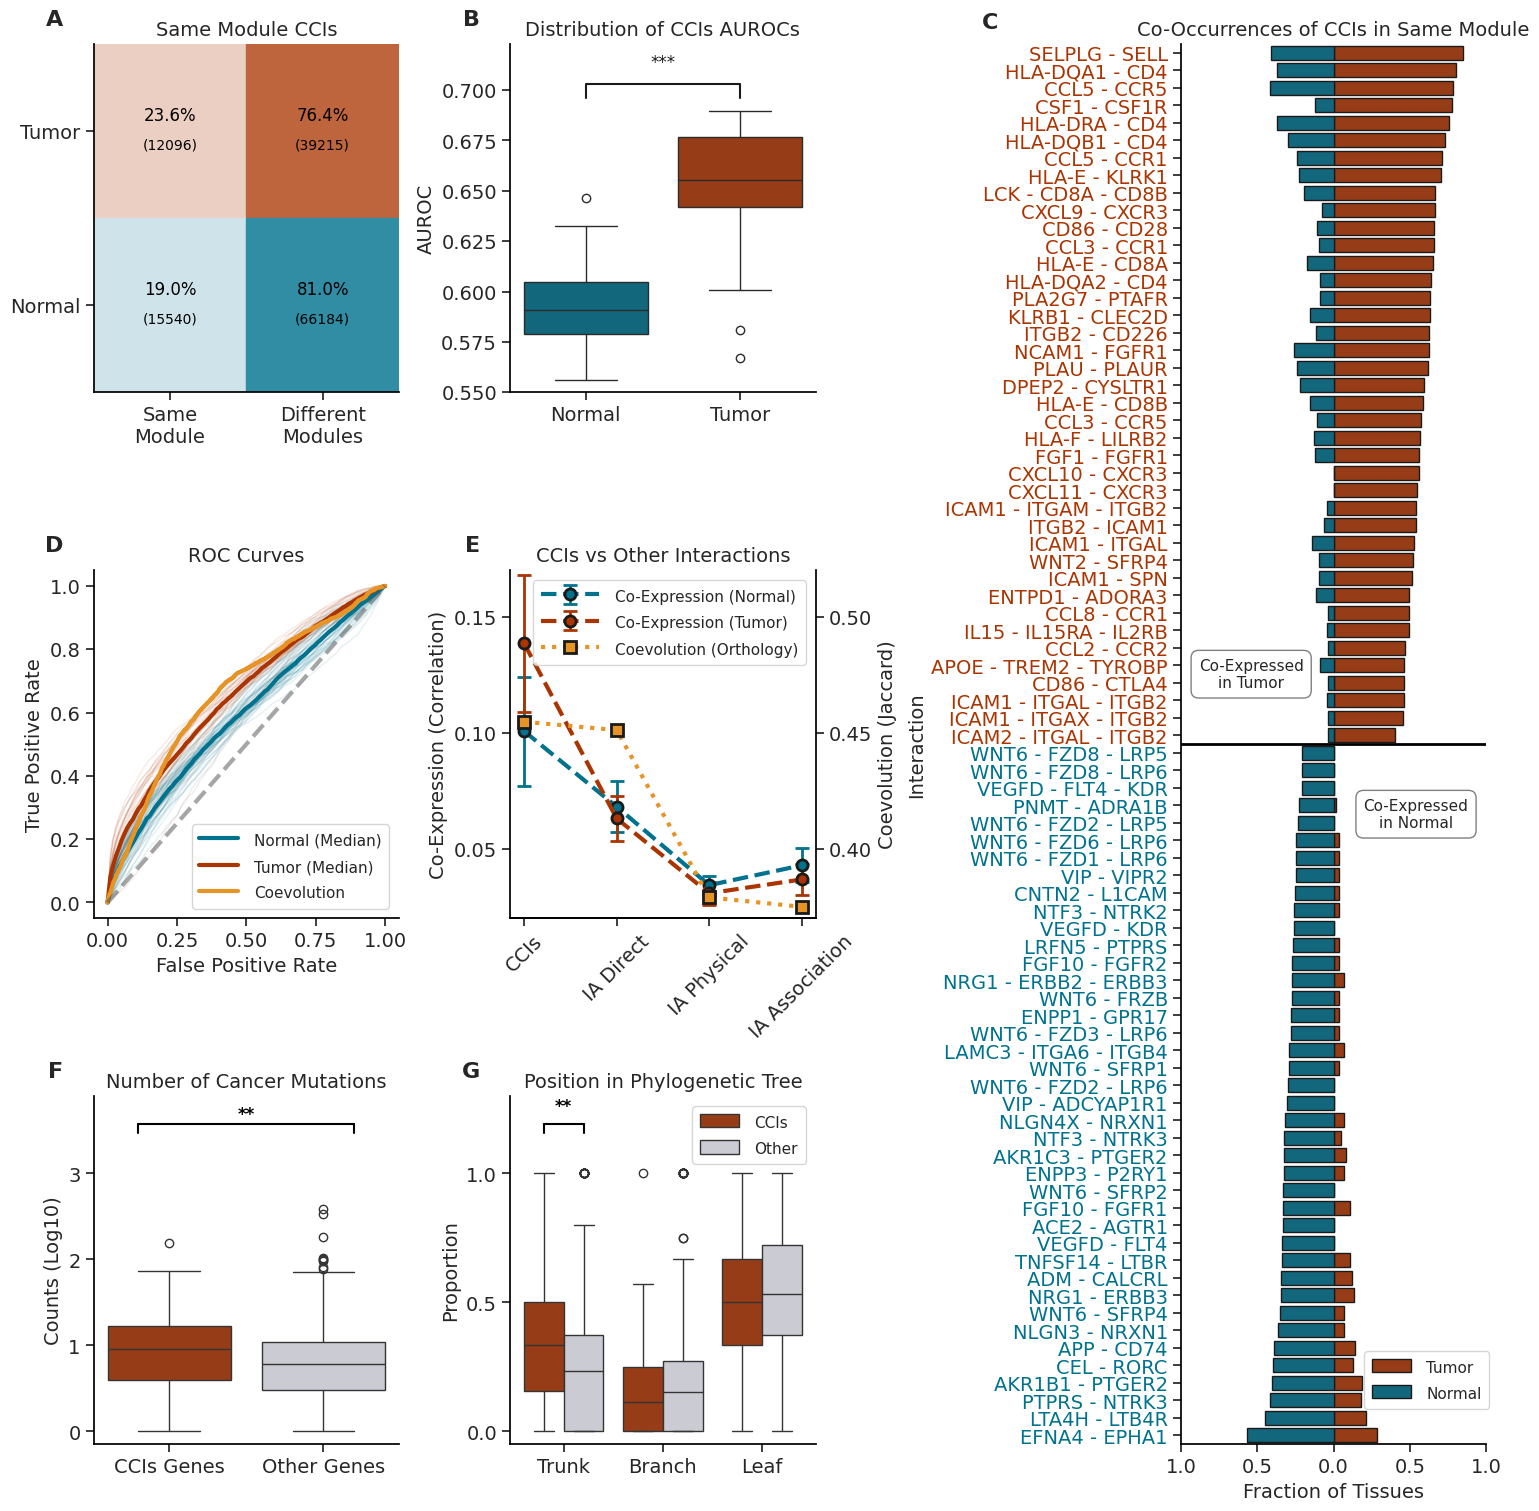

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact, mannwhitneyu
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap, Normalize, to_rgb
from matplotlib import gridspec

fs = 14
smallfs = 11

# Your table and Fisher's exact test
table = pd.DataFrame(table, columns=['Same\nModule', 'Different\nModules'], index=['Tumor', 'Normal'])

# Fisher's exact test
fisher_oddsratio, fisher_p_value = fisher_exact(table)

# Row sums for normalization
tumor_sum = table.loc['Tumor'].sum()
normal_sum = table.loc['Normal'].sum()

# Custom linear colormaps from white to your colors
tumor_cmap = LinearSegmentedColormap.from_list("tumor_cmap", ["#ffffff", tcolor])
normal_cmap = LinearSegmentedColormap.from_list("normal_cmap", ["#ffffff", ncolor])

# Set up the figure with the mosaic layout
fig, axes = plt.subplot_mosaic(
    mosaic="""
    ABC
    DEC
    FGC
    """,
    figsize=(15, 15),
    constrained_layout=True
)

################ SAME MODULE CONTINGENCY TABLE ################

# Create the plot for axes['A']
ax = axes['A']

# Draw cells manually in axes['A']
for i in range(table.shape[0]):
    for j in range(table.shape[1]):
        value = table.iloc[i, j]
        if i == 0:
            cmap = tumor_cmap
            norm = Normalize(0, tumor_sum)
            row_sum = tumor_sum
        else:
            cmap = normal_cmap
            norm = Normalize(0, normal_sum)
            row_sum = normal_sum
        color = cmap(norm(value))
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        
        # Calculate normalized value and display it as a percentage
        normalized_value = value / row_sum
        percentage = f"{normalized_value * 100:.1f}%"
        
        # Annotate with the normalized value (percentage) and the absolute value in parentheses
        ax.text(j + 0.5, i + 0.41, percentage, va='center', ha='center', color='black', fontsize=12)
        ax.text(j + 0.5, i + 0.58, f"({value})", va='center', ha='center', color='black', fontsize=10)

# Axes formatting for axes['A']
ax.set_xticks(np.arange(len(table.columns)) + 0.5)
ax.set_xticklabels(table.columns)
ax.set_yticks(np.arange(len(table.index)) + 0.5)
ax.set_yticklabels(table.index)
ax.set_xlim(0, table.shape[1])
ax.set_ylim(0, table.shape[0])
ax.invert_yaxis()
ax.set_title(f"Same Module CCIs", fontsize=14)
#sns.despine(left=True, bottom=True)
ax.tick_params(left=False, bottom=False)

################ AUROCS BOXPLOT ################

# Create the plot for axes['B']
ax2 = axes['B']

# Create boxplot
sns.boxplot(ax=ax2,
            data=df,
            x='condition',
            y='interactions_auroc',
            palette={'tumor': tcolor,'normal': ncolor}
           )
ax2.set_xlabel('')

# Capitalize x labels
ax2.set_xticklabels([label.get_text().capitalize() for label in ax2.get_xticklabels()])

# Set y-axis label to "AUROC"
ax2.set_ylabel('AUROC')

# Title for the boxplot
ax2.set_title('Distribution of CCIs AUROCs', fontsize=14)

# Mann-Whitney U Test for p-value between Tumor and Normal
tumor_auroc = df[df['condition'] == 'tumor']['interactions_auroc']
normal_auroc = df[df['condition'] == 'normal']['interactions_auroc']
stat, p_value_auroc = mannwhitneyu(tumor_auroc, normal_auroc)

# Set y-limit to zoom in on AUROC range
ax2.set_ylim(0.55, 0.75)

# Function to compute p-value for Mann-Whitney U test
def compute_p_value(data, column):
    """Compute p-value for Mann-Whitney U test."""
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    _, p_value = mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
    return p_value

# Function to add significance bars to the boxplot
def add_significance(ax, data, column, p_value):
    """ Adds significance bars to the given axes object based on p-value. """
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # Not significant

    # Calculate maximum y-value and add space for significance bar
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    y_max = max(normal_data.max(), tumor_data.max())
    y_min = min(normal_data.min(), tumor_data.min())
    y_offset = 0.2 * (y_max - y_min if y_max > y_min else 1)

    h = 0.05 * (y_max - y_min)  # Height of the significance bar
    y_bar_start = y_max + h
    y_bar_end = y_max + 2 * h

    x1, x2 = 0, 1
    col = 'k'

    # Plot the significance bar
    ax.plot([x1, x1, x2, x2], [y_bar_start, y_bar_end, y_bar_end, y_bar_start], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y_bar_end + h, significance, ha='center', va='bottom', color=col, fontsize=12)

    # Update the y-axis limit to make space for the significance bar
    ax.set_ylim(top=y_bar_end + h * 3)  # Adding extra space to avoid overlap with titles

# Add significance bar
add_significance(ax2, df, 'interactions_auroc', p_value_auroc)

############## Panel C: Same module fractions barplot #################
ax = axes['C']

N = 40
smdf = pd.concat([
    same_module_fraction.head(N).sort_values(by='tumor_fraction')[::-1],
    same_module_fraction.tail(N).sort_values(by='normal_fraction')
])
smdf['normal_fraction'] *= -1
smdf.index = smdf.index.str.replace('_', ' - ').str.replace('+', ' - ')

sns.barplot(ax=ax, y='interaction', x='tumor_fraction', data=smdf, color=tcolor, alpha=1, label='Tumor', lw=1, edgecolor='k')
sns.barplot(ax=ax, y='interaction', x='normal_fraction', data=smdf, color=ncolor, alpha=1, label='Normal', lw=1, edgecolor='k')

ax.axhline(N - 0.5, color='black', linewidth=2, linestyle='-')

ax.set_xlabel('Fraction of Tissues', fontsize=fs)
ax.set_ylabel('Interaction', fontsize=fs)
ax.tick_params(labelsize=fs)
ax.set_title('Co-Occurrences of CCIs in Same Module', fontsize=fs)

# Labels
props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.5)
ax.text(0.23, 0.55, 'Co-Expressed\nin Tumor', ha='center', va='center', fontsize=smallfs, transform=ax.transAxes, bbox=props)
ax.text(0.77, 0.45, 'Co-Expressed\nin Normal', ha='center', va='center', fontsize=smallfs, transform=ax.transAxes, bbox=props)

# Legend
ax.legend(fontsize=fs, loc=(0.60, 0.025))

# Format x-axis
ax.set_xlim(-1, 1)
ax.set_xticklabels([f'{abs(x):.1f}' for x in ax.get_xticks()])

# Color y-axis labels
y_labels = ax.get_yticklabels()
for i, label in enumerate(y_labels):
    label.set_color(tcolor if i < N else ncolor)

############# Panel D: ROC CURVES ###################

xx = np.linspace(0,1,100)

# ROC for Tumor
path = '/home/lnemati/pathway_crosstalk/results/roc/tumor'
t_yy = []
for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    xx, yy = interpolate_data(fpr, tpr, xx)
    axes['D'].plot(xx, yy, color=tcolor, linestyle='-', lw=1, alpha=0.1)
    t_yy.append(yy)
t_median = np.median(np.array(t_yy), axis=0)

# ROC for Normal
path = '/home/lnemati/pathway_crosstalk/results/roc/normal'
n_yy = []
for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    xx, yy = interpolate_data(fpr, tpr, xx)
    axes['D'].plot(xx, yy, color=ncolor, linestyle='-', lw=1, alpha=0.1)
    n_yy.append(yy)
n_median = np.median(np.array(n_yy), axis=0)

# Overlay median and reference lines
axes['D'].plot(xx, n_median, color=ncolor, label='Normal (Median)', lw=lw)
axes['D'].plot(xx, t_median, color=tcolor, label='Tumor (Median)', lw=lw)
axes['D'].plot(coev_fpr, coev_tpr, label='Coevolution', color=orangecolor, lw=lw)
axes['D'].plot(xx, xx, color=graycolor2, label='', linestyle='--', lw=lw)

# Format Panel D
axes['D'].set_title('ROC Curves', fontsize=fs)
axes['D'].set_xlabel('False Positive Rate', fontsize=fs)
axes['D'].set_ylabel('True Positive Rate', fontsize=fs)
axes['D'].legend(fontsize=fs)
axes['D'].tick_params(axis='both', labelsize=fs)
axes['D'].spines[['right', 'top']].set_visible(False)

################ PANEL E: Co-Expression and Coevolution ################

# Assign existing panel E axes
ax1 = axes['E']
ax2 = ax1.twinx()  # Twin y-axis for coevolution

# Plot coevolution first (background)
coev_means = df_with_coev.query('value_type == "jaccard"').set_index('interaction_type').loc[order].value
coev_plot = ax2.errorbar(x=[0,1,2,3], y=list(coev_means.values), label="Coevolution (Orthology)", **style_coev)

# Plot co-expression on foreground axis
normal_plot = ax1.errorbar(x=range(len(normal_means)), y=normal_means, yerr=normal_stds,
                           label="Co-Expression (Normal)", **style_normal, **errorbar_kwargs)
tumor_plot = ax1.errorbar(x=range(len(tumor_means)), y=tumor_means, yerr=tumor_stds,
                          label="Co-Expression (Tumor)", **style_tumor, **errorbar_kwargs)

# Formatting
ax1.set_ylabel('Co-Expression (Correlation)', fontsize=fs)
ax2.set_ylabel('Coevolution (Jaccard)', fontsize=fs)
ax1.set_xticks(range(len(order)))
ax1.set_xticklabels(order, rotation=45, fontsize=fs)
ax1.set_ylim(0.02, 0.17)
ax2.set_ylim(0.37, 0.52)
ax1.set_title('CCIs vs Other Interactions', fontsize=fs)

ax1.tick_params(labelsize=fs)
ax2.tick_params(labelsize=fs)
ax1.set_yticks([0.05, 0.1, 0.15])
ax2.set_yticks([0.4, 0.45, 0.5])

ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['left', 'top']].set_visible(False)
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
    
ax1.grid(False)  # Remove grid
ax2.grid(False)  # Remove grid
 
# Combined legend
handles = [normal_plot, tumor_plot, coev_plot]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper right', fontsize=fs, handlelength=3.)


# #################### Panels F and G: MUTATIONS BOXPLOTS #########################

# Melt data for plotting
data = pd.DataFrame({
    'Comparison': (['log10 Total'] * len(total_ccc_log10) + ['log10 Total'] * len(total_not_ccc_log10) +
                   ['Trunk'] * len(genes_ccc_norm['Trunk']) + ['Trunk'] * len(genes_not_ccc_norm['Trunk']) +
                   ['Branch'] * len(genes_ccc_norm['Branch']) + ['Branch'] * len(genes_not_ccc_norm['Branch']) +
                   ['Leaf'] * len(genes_ccc_norm['Private']) + ['Leaf'] * len(genes_not_ccc_norm['Private'])),
    'Gene Type': (['CCIs Genes'] * len(total_ccc_log10) + ['Other Genes'] * len(total_not_ccc_log10) +
                  ['CCIs Genes'] * len(genes_ccc_norm['Trunk']) + ['Other Genes'] * len(genes_not_ccc_norm['Trunk']) +
                  ['CCIs Genes'] * len(genes_ccc_norm['Branch']) + ['Other Genes'] * len(genes_not_ccc_norm['Branch']) +
                  ['CCIs Genes'] * len(genes_ccc_norm['Private']) + ['Other Genes'] * len(genes_not_ccc_norm['Private'])),
    'Value': np.concatenate([total_ccc_log10, total_not_ccc_log10,
                             genes_ccc_norm['Trunk'], genes_not_ccc_norm['Trunk'],
                             genes_ccc_norm['Branch'], genes_not_ccc_norm['Branch'],
                             genes_ccc_norm['Private'], genes_not_ccc_norm['Private']])
})

counts = data.query('Comparison == "log10 Total"')
fracs = data.query('Comparison != "log10 Total"')

# Plot Panel F: Total counts
sns.boxplot(
    x='Gene Type',
    y='Value',
    hue='Gene Type',
    data=counts,
    palette={'CCIs Genes': tcolor, 'Other Genes': lightgray},
    ax=axes['F']
)
axes['F'].set_title('Number of Cancer Mutations', fontsize=fs)
axes['F'].set_xlabel("", fontsize=fs)
axes['F'].set_ylabel("Counts (Log10)", fontsize=fs)
axes['F'].set_ylim(-0.15,3.9)
axes['F'].set_yticks([0,1,2,3])

# Plot Panel G: Trunk/Branch/Private fractions
sns.boxplot(
    x='Comparison',
    y='Value',
    hue='Gene Type',
    data=fracs,
    palette={'CCIs Genes': tcolor, 'Other Genes': lightgray},
    ax=axes['G']
)
axes['G'].set_title('Position in Phylogenetic Tree', fontsize=fs)
axes['G'].set_xlabel("", fontsize=fs)
axes['G'].set_ylabel("Proportion", fontsize=fs)
axes['G'].set_ylim(-0.05,1.3)
axes['G'].set_yticks([0,0.5,1])

# Update legend labels for Panel G only
handles, labels = axes['G'].get_legend_handles_labels()
new_labels = ['CCIs' if 'CCIs Genes' in label else 'Other' for label in labels]
axes['G'].legend(handles, new_labels, title='', fontsize=fs, loc='upper right')


# Formatting
for key in ['F', 'G']:
    axes[key].spines[['right', 'top']].set_visible(False)
    axes[key].tick_params(labelsize=fs)

# Add significance bars
for i, (comparison, row) in enumerate(results.iterrows()):
    if comparison == "log10 Total":
        which_ax = axes['F']
        x_positions = [0, 1]  # CCC vs Other
    else:
        which_ax = axes['G']
        x_positions = [i - 1]  # Trunk, Branch, Private

    if row['pval_adj'] < 0.05:
        lims = which_ax.get_ylim()
        yrange = lims[1] - lims[0]
        y = lims[0] + 0.92 * yrange

        if which_ax == axes['F']:
            which_ax.plot([x_positions[0] - 0.2, x_positions[1] + 0.2], [y, y], color='black')
            which_ax.plot([x_positions[0] - 0.2, x_positions[0] - 0.2], [y - 0.025 * yrange, y], color='black')
            which_ax.plot([x_positions[1] + 0.2, x_positions[1] + 0.2], [y - 0.025 * yrange, y], color='black')
            which_ax.text(0.5, y + 0.05, '*' * (1 + (row['pval_adj'] < 0.01) + (row['pval_adj'] < 0.001)),
                          ha='center', color='black', weight='bold')
        else:
            which_ax.plot([x_positions[0] - 0.2, x_positions[0] + 0.2], [y, y], color='black')
            which_ax.plot([x_positions[0] - 0.2, x_positions[0] - 0.2], [y - 0.025 * yrange, y], color='black')
            which_ax.plot([x_positions[0] + 0.2, x_positions[0] + 0.2], [y - 0.025 * yrange, y], color='black')
            which_ax.text(x_positions[0], y + 0.05, '*' * (1 + (row['pval_adj'] < 0.01) + (row['pval_adj'] < 0.001)),
                          ha='center', color='black', weight='bold')


# Uniform font sizes for all axes
for ax in axes.values():
    # Set title font size
    ax.title.set_fontsize(fs)
    
    # Set x and y labels font size
    ax.xaxis.label.set_fontsize(fs)
    ax.yaxis.label.set_fontsize(fs)
    
    # Set x and y tick labels font size
    ax.tick_params(axis='both', labelsize=fs)

    # Set legend font size if present
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_fontsize(smallfs)

# Disable grids and enable ticks for all axes
for ax in axes.values():
    ax.grid(False)  # Remove grid
    ax.tick_params(bottom=True, left=True)  # Ensure ticks are visible
    ax.spines[['right', 'top']].set_visible(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

# Panel A: Same Module Contingency Table
ax = axes['A']
ax.text(-0.1, 1.1, 'A', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# Panel B: AUROCS Boxplot
ax = axes['B']
ax.text(-0.1, 1.1, 'B', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# Panel C: Same module fractions barplot
ax = axes['C']
ax.text(-0.6, 1.023, 'C', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# Panel D: ROC Curves
ax = axes['D']
ax.text(-0.1, 1.1, 'D', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# Panel E: Co-Expression and Coevolution
ax1 = axes['E']
ax1.text(-0.1, 1.1, 'E', fontsize=16, fontweight='bold', transform=ax1.transAxes, va='top', ha='right')

# Panel F: Mutations Boxplot
ax = axes['F']
ax.text(-0.1, 1.1, 'F', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# Panel G: Mutations Boxplot (Trunk/Branch/Private)
ax = axes['G']
ax.text(-0.1, 1.1, 'G', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')
       
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig1/fig1.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig1/fig1.svg', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig1/fig1.png', bbox_inches='tight', dpi=300)

# Show the figure
plt.show()


In [86]:
fig_to_panels(fig, axes, output_dir='/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig1/panels')

Saved panel 'Same Module CCIs' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig1/panels/same_module_ccis
Saved panel 'Distribution of CCIs AUROCs' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig1/panels/distribution_of_ccis_aurocs
Saved panel 'Co-Occurrences of CCIs in Same Module' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig1/panels/co-occurrences_of_ccis_in_same_module
Saved panel 'ROC Curves' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig1/panels/roc_curves
Saved panel 'CCIs vs Other Interactions' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig1/panels/ccis_vs_other_interactions
Saved panel 'Number of Cancer Mutations' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig1/panels/number_of_cancer_mutations
Saved panel 'Position in Phylogenetic Tree' to /home/lnemati/pathway_crosstalk/results/figures/mat

In [87]:
import matplotlib.transforms as mtransforms

# Draw the figure so that everything is laid out
fig.canvas.draw()

# Get tight bounding box of both the primary and twin axes
bbox1 = ax_e.get_tightbbox(fig.canvas.get_renderer())
bbox2 = ax2.get_tightbbox(fig.canvas.get_renderer())

# Combine both bounding boxes by passing them as a list to the union method
bbox = mtransforms.Bbox.union([bbox1, bbox2])

# Convert from display units (pixels) to inches
bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())

# Save with correct bounding box including labels and title
fig.savefig("/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig1/panels/ccis_vs_other_interactions.png", dpi=300, bbox_inches=bbox_inches)
fig.savefig("/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig1/panels/ccis_vs_other_interactions.pdf", dpi=300, bbox_inches=bbox_inches)


NameError: name 'ax_e' is not defined

In [82]:
ax_e

<Axes: label='E', title={'center': 'CCIs vs Other Interactions'}, ylabel='Co-Expression (Correlation)'>

In [83]:
ax2

<Axes: label='B', title={'center': 'Distribution of CCIs AUROCs'}, ylabel='AUROC'>

In [254]:
fisher_p_value

1.276746493309555e-87